# mVEP ESI N200 Analysis

EEG Source Imaging, or ESI, is a technique to project EEG sensor data onto its corresponding cortical area. As a result, it allows us to get a better sense of the underlying brain activity than just performing sensor-level analysis (Especially due to the fact we had to rotate EEG caps with non-standard techniques for subjects in this study to expose their V5 between electrodes). 

To do this, we can make use of MNE Python's automated co-registration (a way to match the EEG landmarks to the subject's MRI file). Once we have the brain voxel ESI, we can extract and compare specific cortical areas based on FreeSurfer segmented regions. 

Scripts are primarily written by Joshua Kosnoff. I've tried to give proper credit to 3rd party sites where due. In many cases, MNE-based codes were liberally copied from MNE Python tutorials 

## Functions

Lots of functions for automating the process. In most cases of MNE-based processes, the functions were put together from tutorials on their site.

In [1]:
# Native Python packages
import os.path 
import json
import copy

# Third Party Packages
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import mne

# Scripts within repository
from Outlier_Tests import IQR_Outlier_test
from Raincloud_Plot_Maker import statistical_box_and_whisker

# Silence mne logs
mne.set_log_level('ERROR')

# MNE Toolbox functions for mVEP BCI analysis

def auto_coregister(subject, subject_dir, subject_raw, plot_coreg = True, save_file = True, session_num=""):
    
    # Note: Before running this, you need to make the BEM model for the subject. See the my FreeSurfer Protocol 
    # for the terminal commands on how to do this
     
    # Cribbed from https://mne.tools/dev/auto_tutorials/forward/25_automated_coreg.html.
    # Reformatted into a function by Joshua Kosnoff.

    info = mne.io.read_info(fr"{subject_dir}/{subject_raw}")
    plot_kwargs = dict(
        subject=subject,
        subjects_dir=subject_dir,
        surfaces="head",
        dig=True,
        eeg="projected",
        meg=[],
        show_axes=True,
        coord_frame="auto",
    )
    view_kwargs = dict(azimuth=30, elevation=90, distance=0.6, focalpoint=(0.0, 0.0, 0.0))

    fiducials = "auto"  # get fiducials from fsaverage
    
    coreg = mne.coreg.Coregistration(info, subject, subject_dir, fiducials=fiducials)
    coreg.omit_head_shape_points(distance=5.0 / 1000)  # distance is in meters
    coreg.fit_icp(n_iterations=30, nasion_weight=10.0)
    
    # Visualize the coregistration
    if plot_coreg:
        fig = mne.viz.plot_alignment(info, trans=coreg.trans, **plot_kwargs)
        mne.viz.set_3d_view(fig, **view_kwargs)

    # Save the file to the subject directory
    if save_file:
        mne.write_trans(fr'{subject_dir}/{subject}_{session_num}-trans.fif', coreg.trans, overwrite=True)
    
    return

def make_digitization_fif(subject, subject_dir, path_to_vdhr, path_to_RAS, session_num = ""):
    raw = mne.io.read_raw_brainvision(path_to_vdhr,misc=['ECG', 'EMG', 'FootPad'],preload=False)
    mont = mne.channels.read_dig_localite(path_to_RAS)
    raw.set_montage(mont, match_case=False, on_missing='warn')
    raw.save(fr"{subject_dir}/{subject}_{session_num}_eeg.fif", overwrite=True)
    return

def make_inv_operator(epoched_data, subj='default', 
                      subject_dir='default', 
                      coregistration='default', 
                      conductivity = (0.3, 0.006, 0.3), 
                      verbose = 'ERROR',
                      SNR = 3, plot = False):
    
    # Heavily copied from MNE's source imaging tutorial
    
    # Silence all logs (semi-colons added on to functions for good measure)
    mne.utils.use_log_level(verbose)
    mne.set_log_file(verbose)
    
    # If using default head models:
    if subj == 'default':
        path = str(mne.datasets.sample.data_path())
        subj = 'sample'
        subject_dir = path + r'/subjects'
        coregistration = path + r'/MEG/sample/sample_audvis_raw-trans.fif'
        
    elif coregistration == 'default':
        # Open GUI and get it?
        # write it to and load it from the subject_dir
        pass
    
    # Compute Noise Covariance Matrix
    noise_cov = mne.compute_covariance(
        epoched_data, tmax=0., method=['shrunk', 'empirical'], rank=None);
    
    src = mne.setup_source_space(subject=subj, spacing='oct6', add_dist='patch',
                             subjects_dir=subject_dir);
    
    # Make the BEM model    
    bem_fif = coregistration.replace("-trans", "-bem")
    if os.path.isfile(bem_fif): # check to see if the file already exists  
        bem = mne.read_bem_solution(bem_fif)
    else:
        print(f"Writing BEM file for {bem_fif.split(r'/')[-1].split('-')[0]}")
        model = mne.make_bem_model(subject=subj, ico=4,
                                   conductivity=conductivity,
                                   subjects_dir=subject_dir);
        bem = mne.make_bem_solution(model);
        # save the bem model
        mne.write_bem_solution(bem_fif, bem)
    
    # Compute the Forward Solution
    fwd = mne.make_forward_solution(epoched_data.info, trans=coregistration, src=src, bem=bem,
                                    meg=False, eeg=True, mindist=5.0, n_jobs=None,);

    # Get Inverse Opterator
    evoked = epoched_data.average();
    
    inv_operator = mne.minimum_norm.make_inverse_operator(
        info=evoked.info, 
        forward = fwd, 
        noise_cov = noise_cov);

    # set signal-to-noise ratio (SNR) to compute regularization parameter (λ²)
    lambda2 = 1. / SNR ** 2
    
    return src, inv_operator, lambda2


## Load in the preprocessed EEG data

In the *mVEP EEG Sensor Domain Analysis_Final* notebook, we preprocessed the raw EEG data. Let's re-use the preprocessed data by loading in the pickle file

In [2]:
# Load in the cleaned dataframe (see:  notebook)
preprocessed_df = pd.read_pickle(f"Analysis_Rerun.pkl")
preprocessed_df

,subject,condition,data_epoch,hit
0,Subj01,Non-Modulated,"<EpochsArray | 1 events (all good), -0.2 – 0....",True
1,Subj01,Non-Modulated,"<EpochsArray | 1 events (all good), -0.2 – 0....",True
2,Subj01,Non-Modulated,"<EpochsArray | 1 events (all good), -0.2 – 0....",True
3,Subj01,Non-Modulated,"<EpochsArray | 1 events (all good), -0.2 – 0....",True
4,Subj01,Non-Modulated,"<EpochsArray | 1 events (all good), -0.2 – 0....",True
...,...,...,...,...
5157,Subj25,tFUS-GP,"<EpochsArray | 1 events (all good), -0.2 – 0....",True
5158,Subj25,tFUS-GP,"<EpochsArray | 1 events (all good), -0.2 – 0....",True
5159,Subj25,tFUS-GP,"<EpochsArray | 1 events (all good), -0.2 – 0....",True
5160,Subj25,tFUS-GP,"<EpochsArray | 1 events (all good), -0.2 – 0....",True


In [3]:
print(len(np.unique(preprocessed_df.subject)))

25


## DATA PATHS

NOTE: Some subjects had errors with the segmented MRI files. 
There does not seem to an easy fix for this (though it looks possible with manual editing of their 3D render) --> 
For now, using the default MRI brain model in their place. 

ALSO NOTE: Since testing data generally yeilded high error, I analyzed the neural data from the **training** sets.
This should (theorectically) increase the likelihood that the subjects were looking at the proper letter for each
trial (especially for the earlier cases, where we did not use an indicator in the testing session)


In [4]:
###################################################
# CHANGE THESE PATHS - the relative paths for box should be the same. You may need to change
# the relative FreeSurfer paths if you have different nomenclature or organization methods

path_to_file_paths = r"file_paths_remapped.json"
path_to_box = r"/Users/jkosnoff/Library/CloudStorage/Box-Box/Joshua-Speller-Paper/Data/EEG_Data/"

path_to_freesurfer = path_to_box + r'/Freesurfer' # r"/Users/jkosnoff/Documents/Freesurfer"
path_to_freesurfer = r"/Users/jkosnoff/Docs/Freesurfer"
###################################################

## EEG Source Imaging

Now we're ready to perform the EEG Source Imaging. As mentioned earlier, we need to align the EEG landmarks (embedded in the *RAS_file*) with the subject's MRI (*subject_dir* / *head_model*). The code below will create the eeg-digization and co-registration files if they do not already exist (but these can take a long time to make, so it will check if it can load pre-made files first). 

For this study, the three primary areas of interest for theta power analysis are the left (*lh*) V5 (*MT_exvivo*; part of Broddman's labeled dictionary *BA_exvivo*), the superior parietal lobe (*superiorparietal*; Desikan-Killiany Atlas *aparc*), and the inferior temporal gyrus (*inferiortemporal*, Desikan-Killiany Atlas *aparc*). We can extract the average activity in each each region and store it to the designated DataFrame.

In [5]:
# The paracellation dictionary that the labels are in
# Use BA_exvivo.thresh for smaller region
aparcs = ['BA_exvivo', 'aparc', 'aparc']


key_mappings = {"Decoupled-Sham": "Decoupled-Sham", "Non-Modulated":"Non-Modulated", 
               "tFUS-GC":"tFUS", "tFUS-GP": "US-Control"}

# The FreeSurfer labels of interest
BA_regions = ["MT_exvivo-lh",
    "superiorparietal-lh",
    "inferiortemporal-lh"]

with open(path_to_file_paths) as f:
    file_paths = json.load(f)

for aparc, FS_region in zip(aparcs, BA_regions):
    
    # Initialize a new data frame
    ESI_df = pd.DataFrame(columns = ["subject", "condition", "data", "scan_num", "order"])

    for subject in np.unique(preprocessed_df.subject):
        
        # Step 0: Get the relevant paths
        head_model = file_paths[subject]["head_model"]
        subject_dir =  path_to_freesurfer + file_paths[subject]["subject_dir"]
        RAS_file = subject_dir + file_paths[subject]["RAS"]
        session_num = RAS_file.split(r"/")[-2]
        
        # which vhdr file doesn't actually matter since we already have the data in the dataframe
        # we just need to grab the electrode information present in the file (which should be the same
        # across conditions)
        vhdr_file = path_to_box + subject + "r/" + list(file_paths[subject]["vhdr_paths_training"].values())[0]

        # Step 1: Load (or make) the eeg-digitization fif
        subject_digi_fif = head_model + "_" + session_num + "_eeg.fif"

        if not os.path.isfile(subject_dir + r"/" + subject_digi_fif): # check to see if the file already exists
            make_digitization_fif(subject=head_model, subject_dir=subject_dir,
                              path_to_vdhr=vhdr_file, path_to_RAS=RAS_file, session_num=session_num)

        # Step 2: Load (or make) the coregistration fif
        subject_tran_fif = head_model  + "_" + session_num + "-trans.fif"
        if not os.path.isfile(subject_dir + r"/" + subject_tran_fif): #check to see if file already exists
            auto_coregister(subject=head_model, subject_dir=subject_dir, 
                            subject_raw=subject_digi_fif, save_file=True, plot_coreg=False, session_num=session_num)
            
        # Step 3: Load the EEG data               
        for condition in list(file_paths[subject]["vhdr_paths_training"].keys()):
            
            # Since the ESI analysis uses each epoch scan as a trial, the sample size is already much higher 
            # than that of the behavioral outcome data. In an attempt to avoid over-biasing towards certain 
            # subjects, if one subject as data sets for a condition, only consider the first one. 
            
            if condition[-1] not in ["2", "3", "4", "5", "6", "7", "8", "9"]:
                epoch = mne.concatenate_epochs(preprocessed_df["data_epoch"].loc[(preprocessed_df.subject == subject) 
                                                                                 & (preprocessed_df.condition == condition)
                                                                                 & (preprocessed_df.hit == True)
                                                                               ].to_list())
                
                # The MNE inverase operator function requires a data reference.
                epoch.set_eeg_reference('average', projection=True)
                
                # Step 4: Make the inverse operator
                src, inv_operator, lambda2 = make_inv_operator(
                        epoched_data= epoch, 
                        subj=head_model, 
                        subject_dir=subject_dir, 
                        coregistration=subject_dir + r"/" + subject_tran_fif)

                # Step 5: Extract source imaging time series
                # Get the FreeSurfer Labels for the specified region and parcellation
                labels = mne.read_labels_from_annot(head_model, parc=aparc, subjects_dir=subject_dir, regexp=FS_region)

                stcs = mne.minimum_norm.apply_inverse_epochs(epoch, 
                                                             inv_operator,
                                                             lambda2=lambda2,
                                                             method='MNE');  # MNE, or dSPM, sLORETA
                for i, stc in enumerate(stcs):
                    ts = mne.extract_label_time_course(stcs = stc, 
                                                        labels = labels,
                                                        src=src)

                    ESI_df.loc[len(ESI_df)] = {"subject": subject, "condition": condition, 
                                               "data": ts.flatten(), "scan_num": i, 
                                               "order": file_paths[subject]['order'][key_mappings[condition]]}
    
    # Save the data to a dataframe / pickle
    ESI_df.to_pickle(f"Analysis_Rerun_{FS_region}.pkl")     

/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarnin

/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarnin

/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarnin

/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarnin

/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarnin

/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarnin

/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarning: Log entries will be appended to the file. Use overwrite=False to avoid this message in the future.
  mne.set_log_file(verbose)
/var/folders/yy/4qhb9qd51zxgxb1p39j8bnnm0000gn/T/ipykernel_93638/1942503868.py:79: RuntimeWarnin

In [6]:
condition

'Decoupled-Sham'

In [7]:
ESI_df.head()

,subject,condition,data,scan_num,order
0,Subj01,tFUS-GC,"[6.25844961958003e-12, 4.4786324621168955e-12,...",0,2
1,Subj01,tFUS-GC,"[4.089245422373442e-12, 1.9210146718524333e-11...",1,2
2,Subj01,tFUS-GC,"[5.6560526907891434e-12, 7.1995791125579404e-1...",2,2
3,Subj01,tFUS-GC,"[3.6170207019923347e-12, 1.7559302076767892e-1...",3,2
4,Subj01,tFUS-GC,"[4.152409647167458e-12, 1.70624367021901e-11, ...",4,2


## Data Analysis

Because we're using repeated samples, we can't use the 'usual suspects' in neural data analysis (i.e., Kruskal Wallis / ANOVA, Wilcoxon / t-test) immediately. Instead, we need to fit the data to linear mixed effect models and treat the subjects as random effect variables. This will be done in R, so let's extract the N200 frequency band power for each band and export it to a csv. Once the data is fit to a linear mixed effect model, we can run z-tests on the model itself.

We will use Morlet Wavelet tranformations to get the associated time-frequency band powers and take the mean over the window (100 - 250 ms). 

We will also use the IQR test to remove outliers for each condition from the power analysis. 

In [8]:
window = range(30, 46) # 100 - 250 ms post simulus onet


# Superior parietal beta, theta, alpha all significantly different
def return_power(array, freqs =  np.arange(12, 31, 1), mark_outliers = True, window = window):
    
    n_cycles = freqs / (2 * freqs[0]) # Morlet wavelet cycles; based on MNE's tutorial

    power = mne.time_frequency.tfr_array_morlet(
                np.expand_dims(array, 1), sfreq = 100.0, 
                freqs = freqs, n_cycles = n_cycles, output='power')[:,:,:,window].mean(axis=-1).mean(axis=-1).mean(axis=-1)
    
    if mark_outliers:
        # Marks outliers as NaNs
        
        power[np.array(IQR_Outlier_test(power))] = np.nan
    
        # power[double_mads_from_median(power) >= 3.5] = np.nan
    
    return power


FS_regions = ['MT_exvivo-lh', 'superiorparietal-lh', 'inferiortemporal-lh']
regions = ['V5', 'SP', 'IT']

for FS_region, region in zip(FS_regions, regions):

    # Load in Data Frame
    df = pd.read_pickle(f"Analysis_Rerun_{FS_region}.pkl")

    # Filter data from 1 - 40 Hz (this should have already been done in the preprocessing, but just in case autoreject / ICA removal messed something up :) ) 
    df["filtered_data"] = list(mne.filter.filter_data(np.vstack(df["data"].values), sfreq=100.0, l_freq=1, h_freq=40))

    # Z-Score based on 200 ms baseline
    df["filtered_data"] =  df["filtered_data"].apply(lambda x: ((x - x[0:20].mean()) / x[0:20].std()) )

    # Initialize Power Column
    df['power'] = np.nan

    freqs = [np.arange(4, 8, 1),  np.arange(8, 12, 1),  np.arange(12, 30, 1), np.arange(30, 40, 1)]
    names = ["theta", "alpha", "beta", "gamma"]

    for freq, name in zip(freqs, names):
        my_df = copy.deepcopy(df)
        for cond in np.unique(df.condition):
#             my_df["power"].loc[my_df.condition == cond] = return_power(np.vstack(my_df['filtered_data'].loc[my_df.condition == cond]), 
#                                                                        freqs = freq)
            condition_mask = (my_df['condition'] == cond)
            my_df.loc[condition_mask, 'power'] = return_power(np.vstack(my_df.loc[condition_mask, 'filtered_data']), freqs=freq)
        
        # Drop the nans (aka drop outliers)
        my_df = my_df.dropna()

        # Print to csv file
        my_df.to_csv(f"/Users/jkosnoff/Downloads/Analysis_Rerun_{region}_{name}_powers-IQR.csv")

## Plotting

We'll save the p-values from R and plug those into our statistical box and whisker plotting function

# V5

theta Non-Modulated 5.7440569581011 4.358627364393758
theta tFUS-GC 7.29004969929018 5.967192727231526
theta Decoupled-Sham 5.106959103818912 3.7424431281506547
theta tFUS-GP 6.840392270304888 5.577349180608277
[[(2, 4), 0.04952444], [(2, 1), 1.998401e-15], [(2, 3), 0.0], [(1, 4), 1.510231e-07], [(3, 4), 1.332268e-15], [(1, 3), 0.0001035045]]
Comparison between tFUS-GC and tFUS-GP: 0.04952
Comparison between tFUS-GC and Non-Modulated: 0.00000
Comparison between tFUS-GC and Decoupled-Sham: 0.00000
Comparison between Non-Modulated and tFUS-GP: 0.00000
Comparison between Decoupled-Sham and tFUS-GP: 0.00000
Comparison between Non-Modulated and Decoupled-Sham: 0.00010


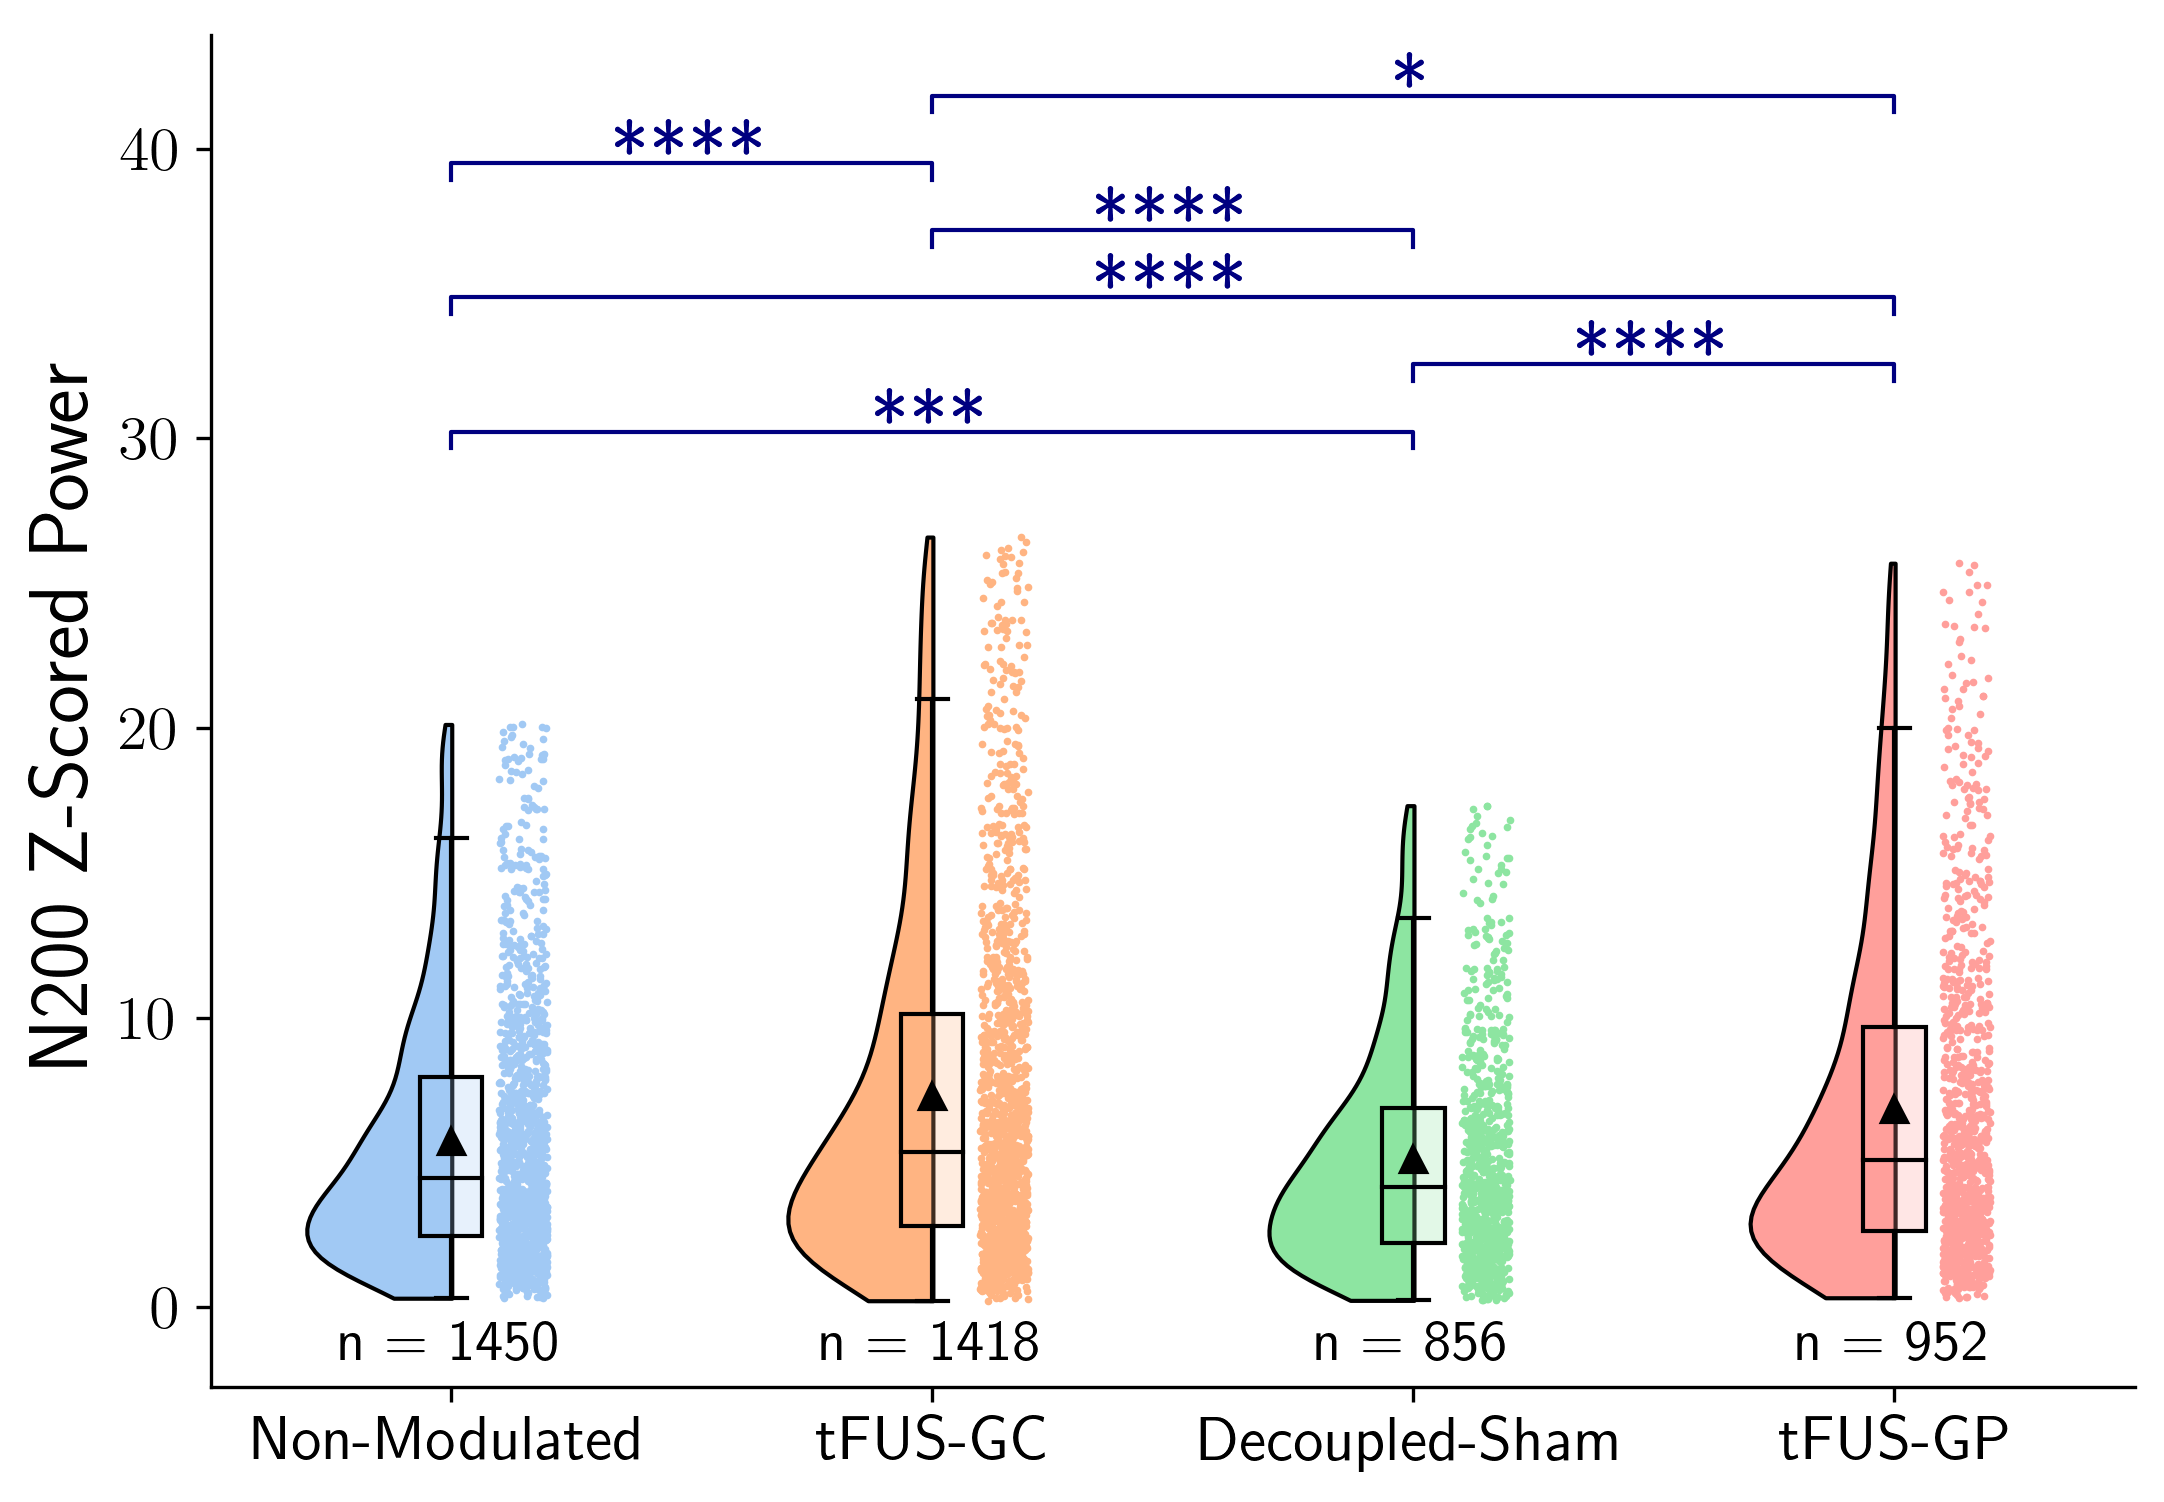

alpha Non-Modulated 4.7479321363860025 3.234556375687742
alpha tFUS-GC 5.594283429872694 4.098279919383791
alpha Decoupled-Sham 4.382601123744562 2.907478009723401
alpha tFUS-GP 5.246966036673935 3.7874984264551497
[[(2, 4), 0.02040771], [(2, 1), 1.196037e-09], [(2, 3), 0.0], [(1, 4), 0.0006934179], [(3, 4), 4.543794e-09], [(1, 3), 0.0006934179]]
Comparison between tFUS-GC and tFUS-GP: 0.02041
Comparison between tFUS-GC and Non-Modulated: 0.00000
Comparison between tFUS-GC and Decoupled-Sham: 0.00000
Comparison between Non-Modulated and tFUS-GP: 0.00069
Comparison between Decoupled-Sham and tFUS-GP: 0.00000
Comparison between Non-Modulated and Decoupled-Sham: 0.00069


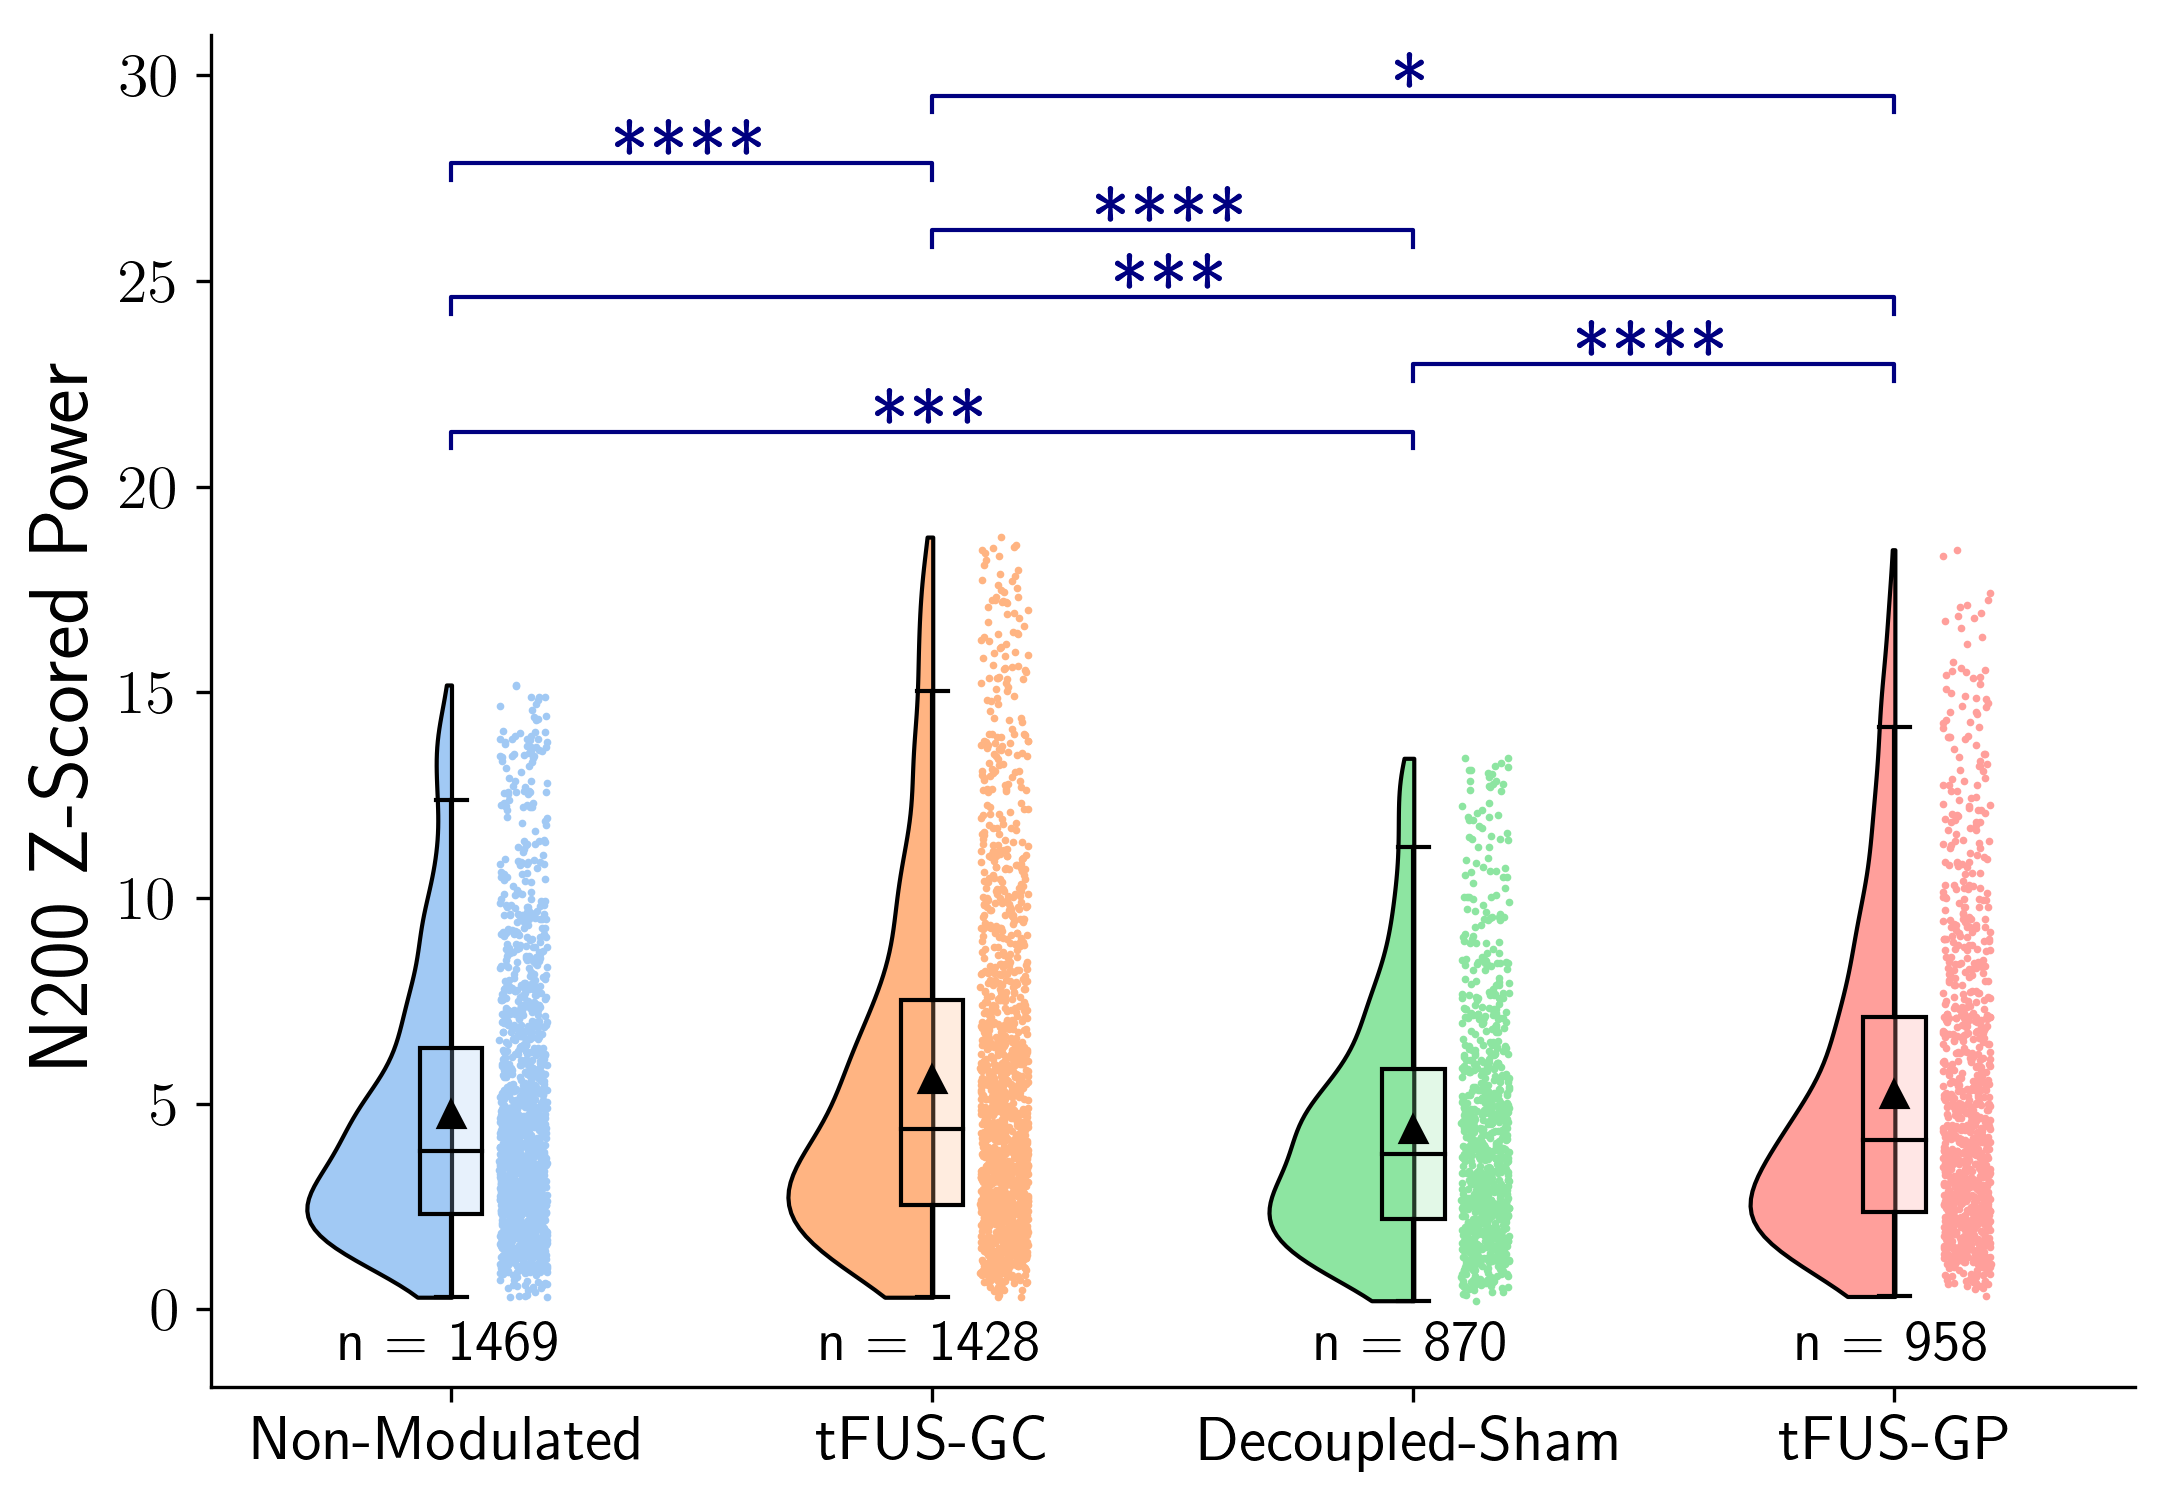

beta Non-Modulated 3.5147272430184806 2.153015610293372
beta tFUS-GC 3.817590218209371 2.4260960476632336
beta Decoupled-Sham 3.322283429724582 1.9554724925326004
beta tFUS-GP 3.697675349068359 2.382543133653462
[[(2, 1), 0.0004701296], [(2, 3), 7.649686e-07], [(1, 4), 0.02967758], [(3, 4), 0.0002279312], [(1, 3), 0.0188473]]
Comparison between tFUS-GC and Non-Modulated: 0.00047
Comparison between tFUS-GC and Decoupled-Sham: 0.00000
Comparison between Non-Modulated and tFUS-GP: 0.02968
Comparison between Decoupled-Sham and tFUS-GP: 0.00023
Comparison between Non-Modulated and Decoupled-Sham: 0.01885


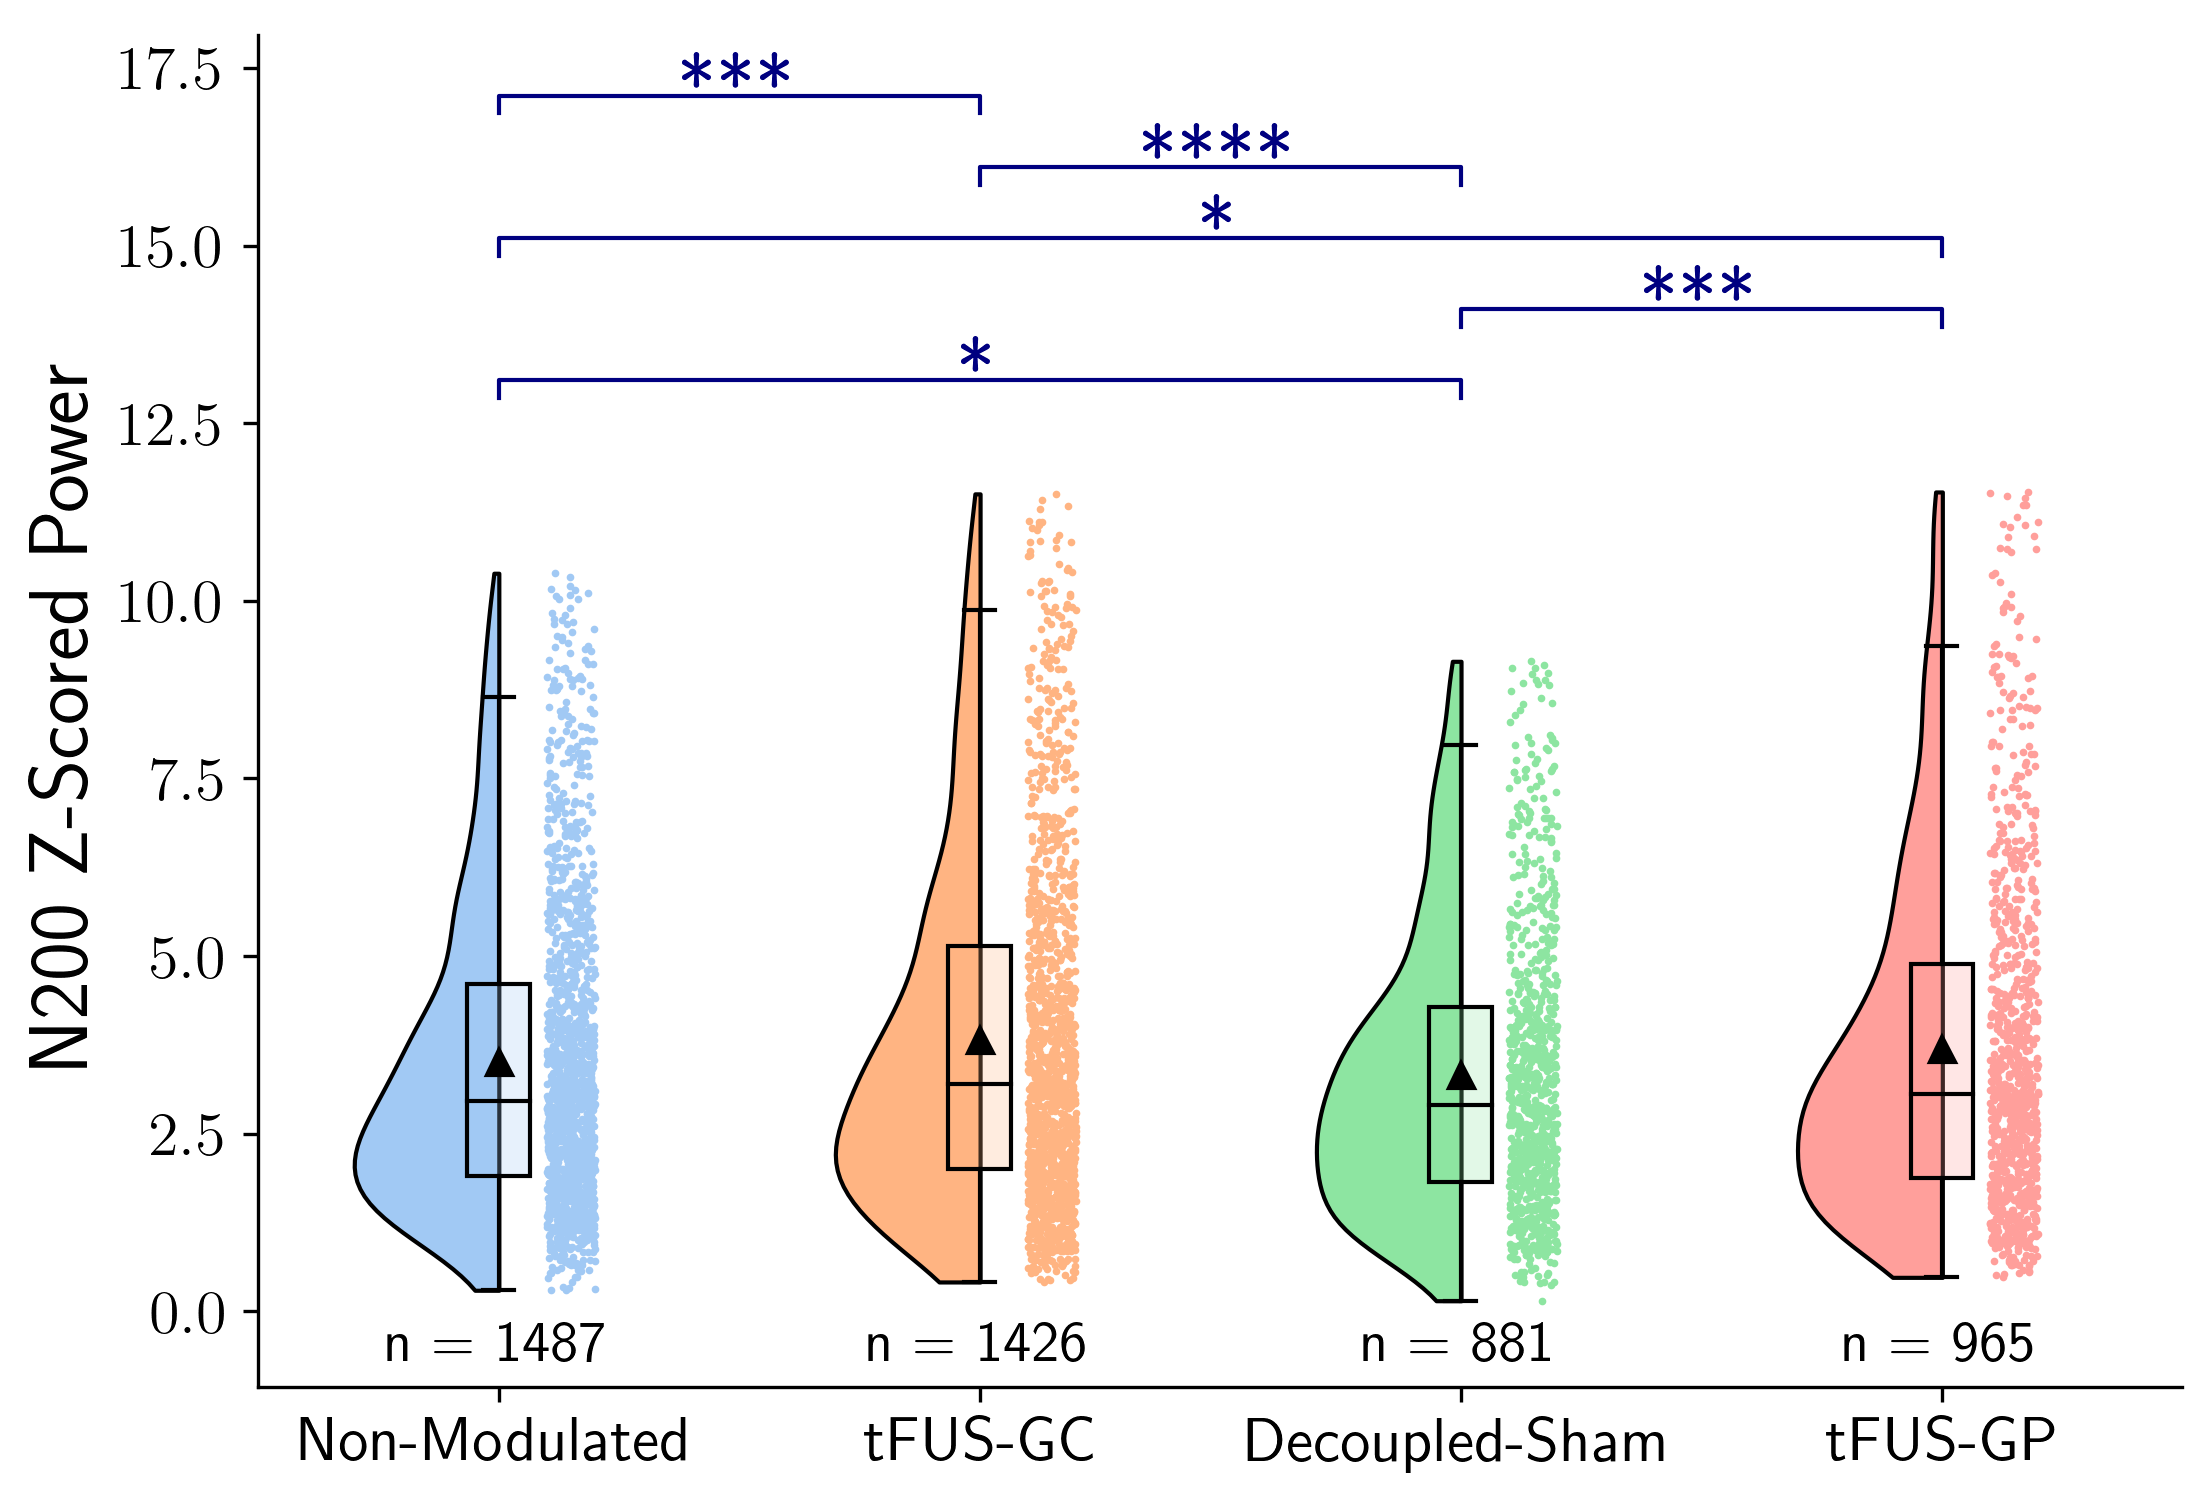

gamma Non-Modulated 3.197336029634107 1.9283290253190208
gamma tFUS-GC 3.477803181921451 2.1981051288041495
gamma Decoupled-Sham 3.058055047064711 1.7888135829318714
gamma tFUS-GP 3.348077049908488 2.128637088376162
[[(2, 1), 0.0005002073], [(2, 3), 3.99152e-06], [(1, 4), 0.04534669], [(3, 4), 0.001145633], [(1, 3), 0.04534669]]
Comparison between tFUS-GC and Non-Modulated: 0.00050
Comparison between tFUS-GC and Decoupled-Sham: 0.00000
Comparison between Non-Modulated and tFUS-GP: 0.04535
Comparison between Decoupled-Sham and tFUS-GP: 0.00115
Comparison between Non-Modulated and Decoupled-Sham: 0.04535


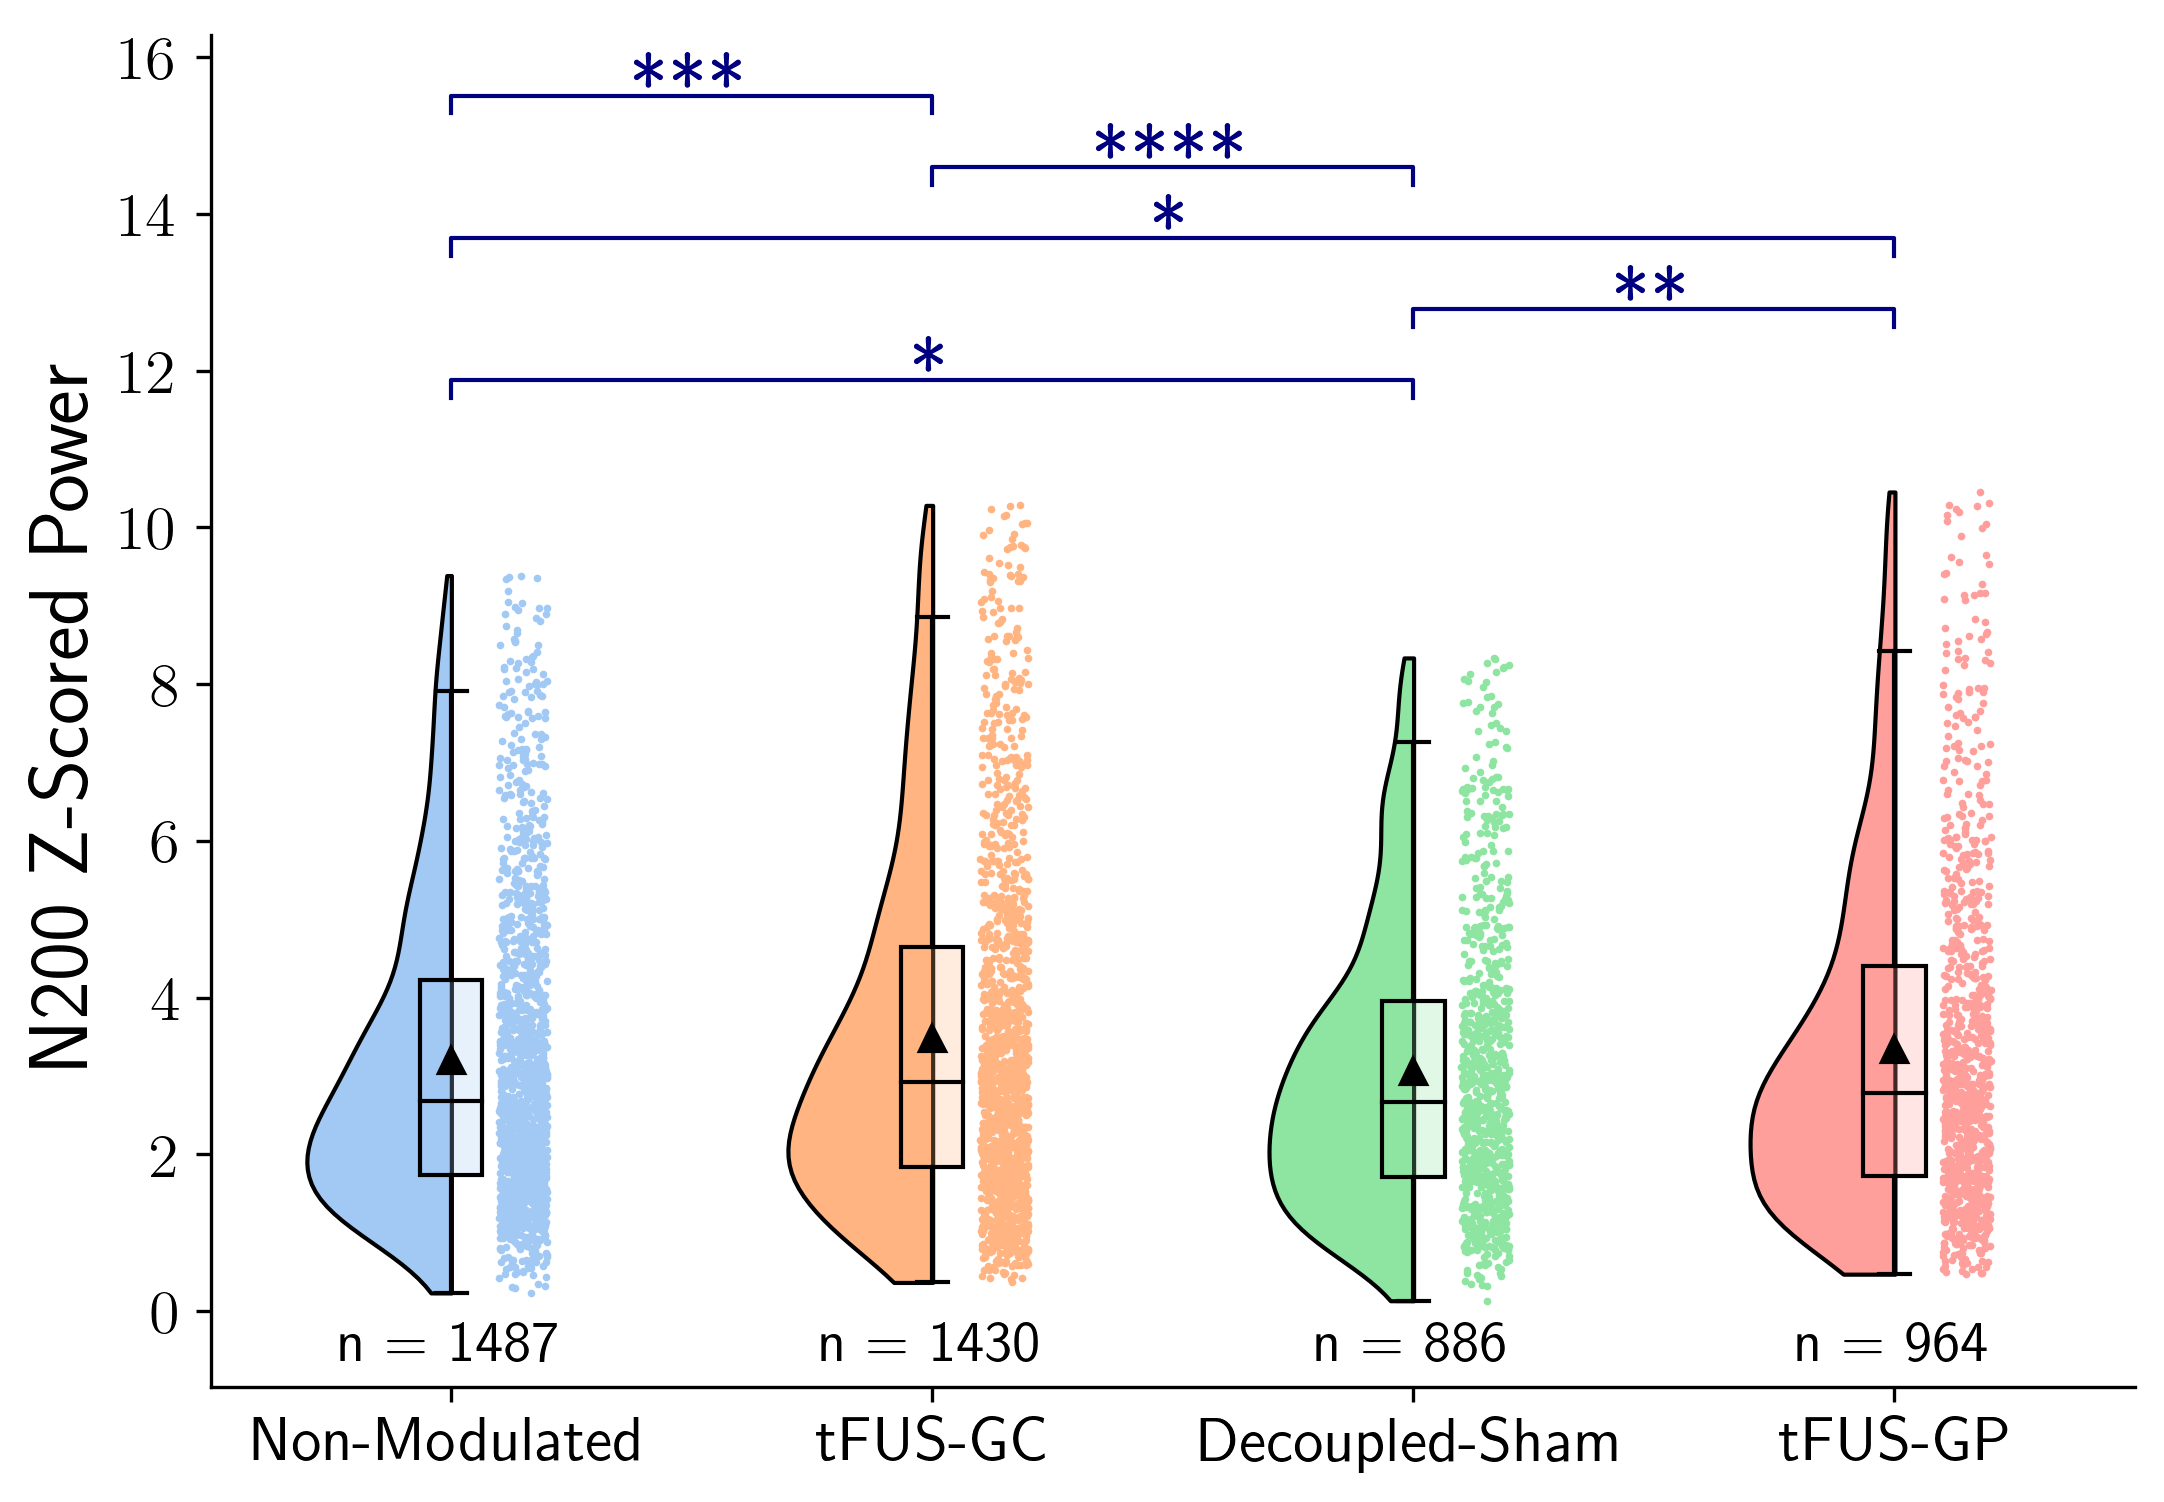

In [15]:
# P-Values were computed in R using lmer test

theta_ps = [
            [(2, 4), 4.952444e-02], # tFUS-US-Control
            [(2, 1), 1.998401e-15], # tFUS-NonModulated
            [(2, 3), 0.000000e+00], # tFUS-Decoupled
            [(1, 4), 1.510231e-07], # US-Control - NonModulated
            [(3, 4), 1.332268e-15], # US-Control - Decoupled Sham
            [(1, 3), 1.035045e-04], # Non-modulated - Decoupled-Sham
           ]

alpha_ps = [
            [(2, 4), 2.040771e-02], # tFUS-US-Control
            [(2, 1), 1.196037e-09], # tFUS-NonModulated
            [(2, 3), 0.000000e+00], # tFUS-Decoupled
            [(1, 4), 6.934179e-04], # US-Control - NonModulated
            [(3, 4), 4.543794e-09], # US-Control - Decoupled Sham
            [(1, 3), 6.934179e-04], # Non-modulated - Decoupled-Sham
           ]

beta_ps = [
            [(2, 1), 4.701296e-04], # tFUS-NonModulated
            [(2, 3), 7.649686e-07], # tFUS-Decoupled
            [(1, 4), 2.967758e-02], # US-Control - NonModulated
            [(3, 4), 2.279312e-04], # US-Control - Decoupled Sham
            [(1, 3), 1.884730e-02], # Non-modulated - Decoupled-Sham
           ]

gamma_ps = [
            [(2, 1), 5.002073e-04], # tFUS-NonModulated
            [(2, 3), 3.991520e-06], # tFUS-Decoupled
            [(1, 4), 4.534669e-02], # US-Control - NonModulated
            [(3, 4), 1.145633e-03], # US-Control - Decoupled Sham
            [(1, 3), 4.534669e-02], # Non-modulated - Decoupled-Sham
           ]


ps = [theta_ps, alpha_ps, beta_ps, gamma_ps]
for i, name in enumerate(["theta", "alpha", "beta", "gamma"]):

    my_df = pd.read_csv(f"/Users/jkosnoff/Downloads/Analysis_Rerun_V5_{name}_powers-IQR.csv")

    power_dicts = {}
    for cond in np.unique(my_df.condition):
        power_dicts[cond] = my_df["power"].loc[my_df.condition == cond].values


    data = []
    keys = ["Non-Modulated", "tFUS-GC", "Decoupled-Sham", "tFUS-GP"]
    for key in keys:
        data.append(power_dicts[key])
        print(name, key, np.mean(power_dicts[key]), np.std(power_dicts[key]))
        

    # Significant p values calculate in R w/ mixed effect modeling
    

    title = "" #r'Single Trial Euclidean Error, Normalized wrt $\sqrt{Scan Epochs}$ * Sonications'
    statistical_box_and_whisker(data, keys,
                                plot_type='raincloud',
                                title = "", 
                                y_label=r'N200 Z-Scored Power', 
                                print_ps = True, 
                                font = 'Arial',
                                show_means=True, 
                                passed_ps=True,
                                significant_combinations = ps[i],
                                sig_color = 'navy',
                                save_fig = f"V5_{name}_N200.svg",
                                dpi = 300.0)

# SP

theta Non-Modulated 6.780622334922019 5.186224455691632
theta tFUS-GC 7.839795258253753 6.269702658218592
theta Decoupled-Sham 6.618347005047005 4.981598707543627
theta tFUS-GP 6.961668989472453 5.296227670550778
[[(2, 4), 3.226685e-05], [(2, 1), 1.203403e-06], [(2, 3), 1.790883e-08]]
Comparison between tFUS-GC and tFUS-GP: 0.00003
Comparison between tFUS-GC and Non-Modulated: 0.00000
Comparison between tFUS-GC and Decoupled-Sham: 0.00000


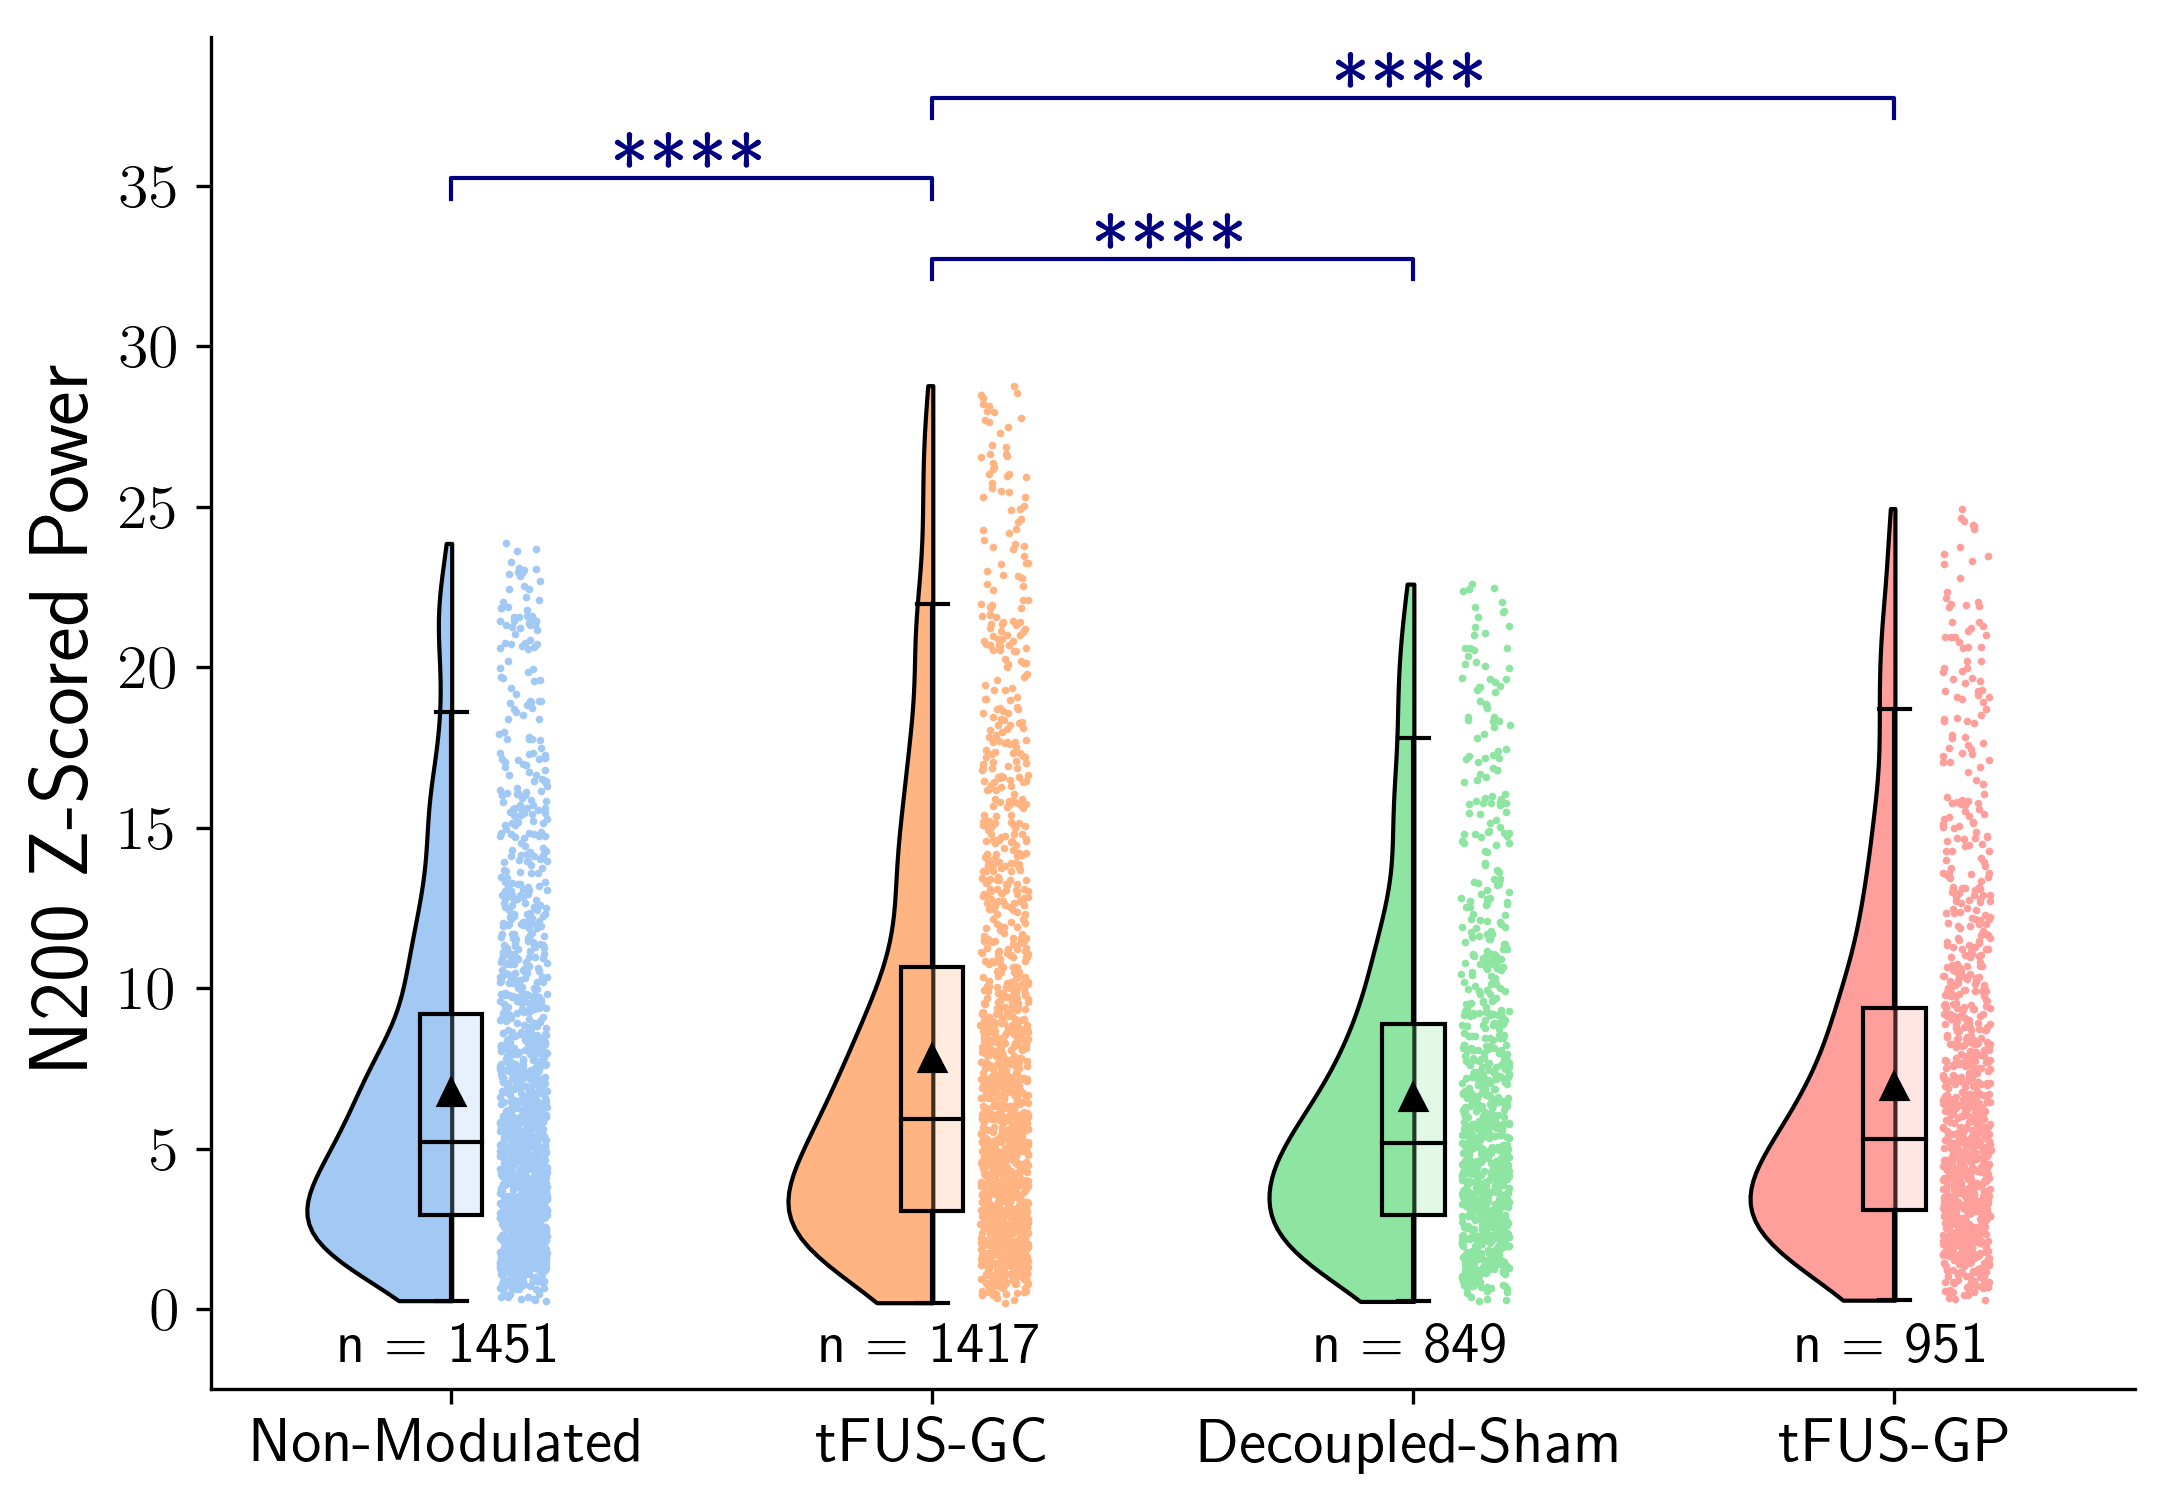

alpha Non-Modulated 5.29925164938658 3.6939167182316144
alpha tFUS-GC 5.790734494333668 4.164343684965779
alpha Decoupled-Sham 5.340269422417003 3.6557456975115894
alpha tFUS-GP 5.294180793518292 3.596140666837342
[[(2, 4), 0.001240029], [(2, 1), 0.001240029], [(2, 3), 0.001240029]]
Comparison between tFUS-GC and tFUS-GP: 0.00124
Comparison between tFUS-GC and Non-Modulated: 0.00124
Comparison between tFUS-GC and Decoupled-Sham: 0.00124


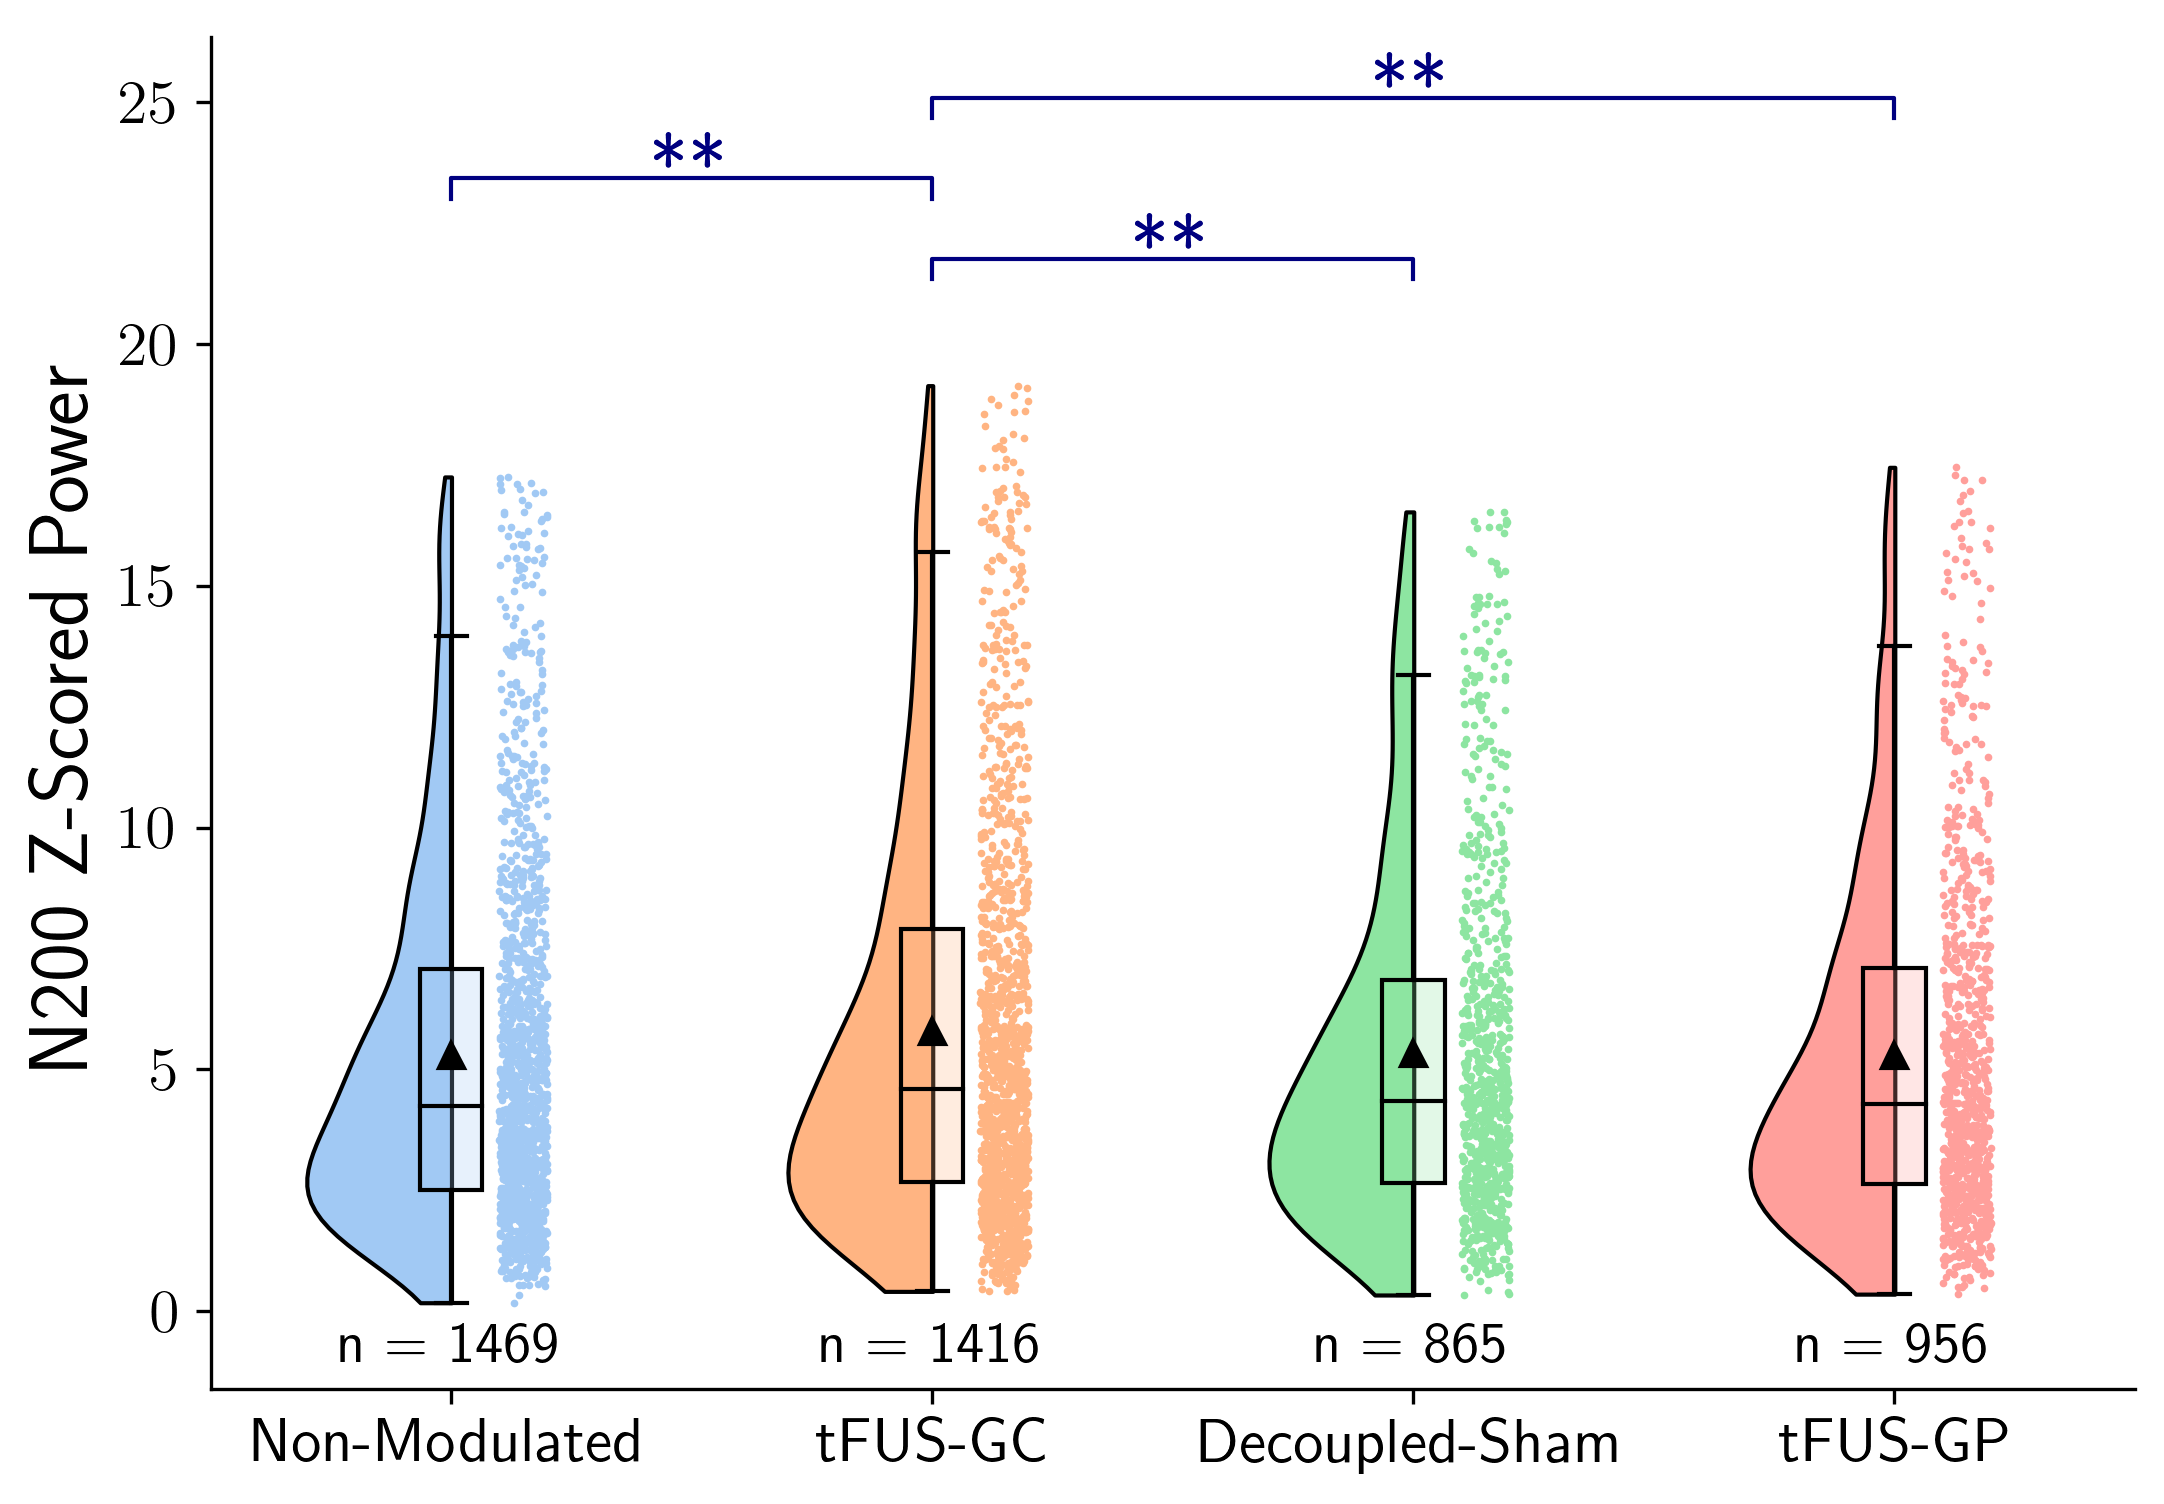

beta Non-Modulated 3.5376366084664594 2.1904955270179665
beta tFUS-GC 3.789845366973168 2.478793308164371
beta Decoupled-Sham 3.705115334822294 2.2730854825140936
beta tFUS-GP 3.657060405677731 2.280202457199368
[[(2, 1), 0.01414606]]
Comparison between tFUS-GC and Non-Modulated: 0.01415


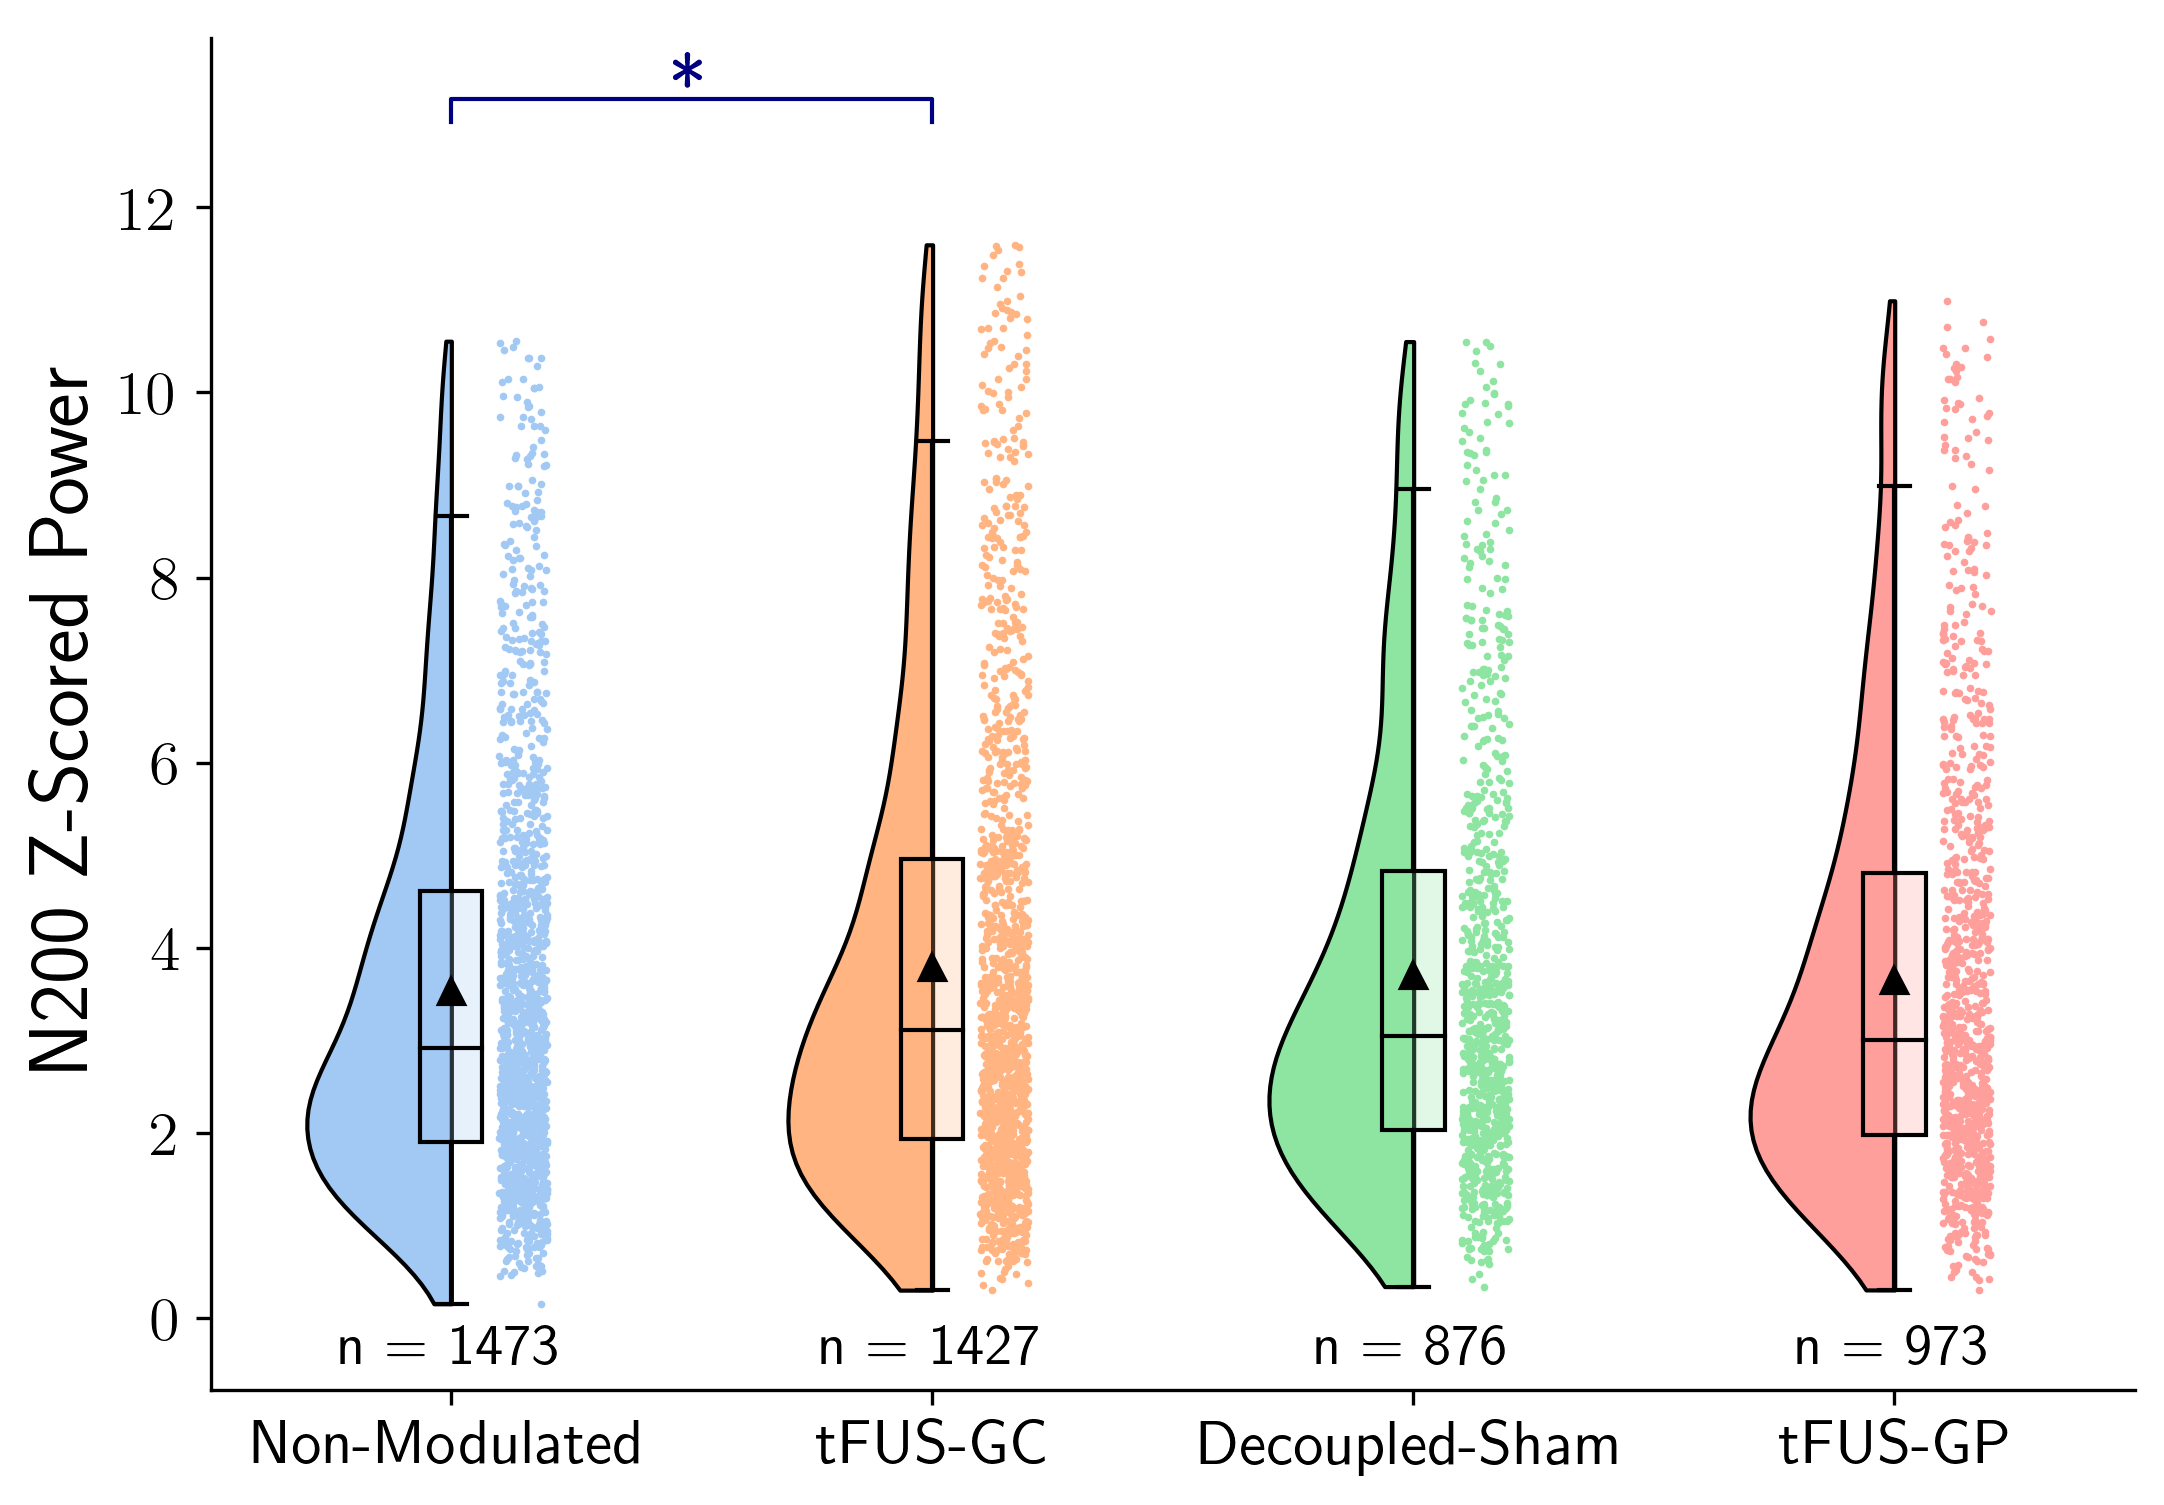

gamma Non-Modulated 3.1632706222250926 1.9330167961427176
gamma tFUS-GC 3.383579475357478 2.191525274119994
gamma Decoupled-Sham 3.308906399519965 2.0006484104835707
gamma tFUS-GP 3.2749877765112925 2.0119654375012854
[[(2, 1), 0.01436557]]
Comparison between tFUS-GC and Non-Modulated: 0.01437


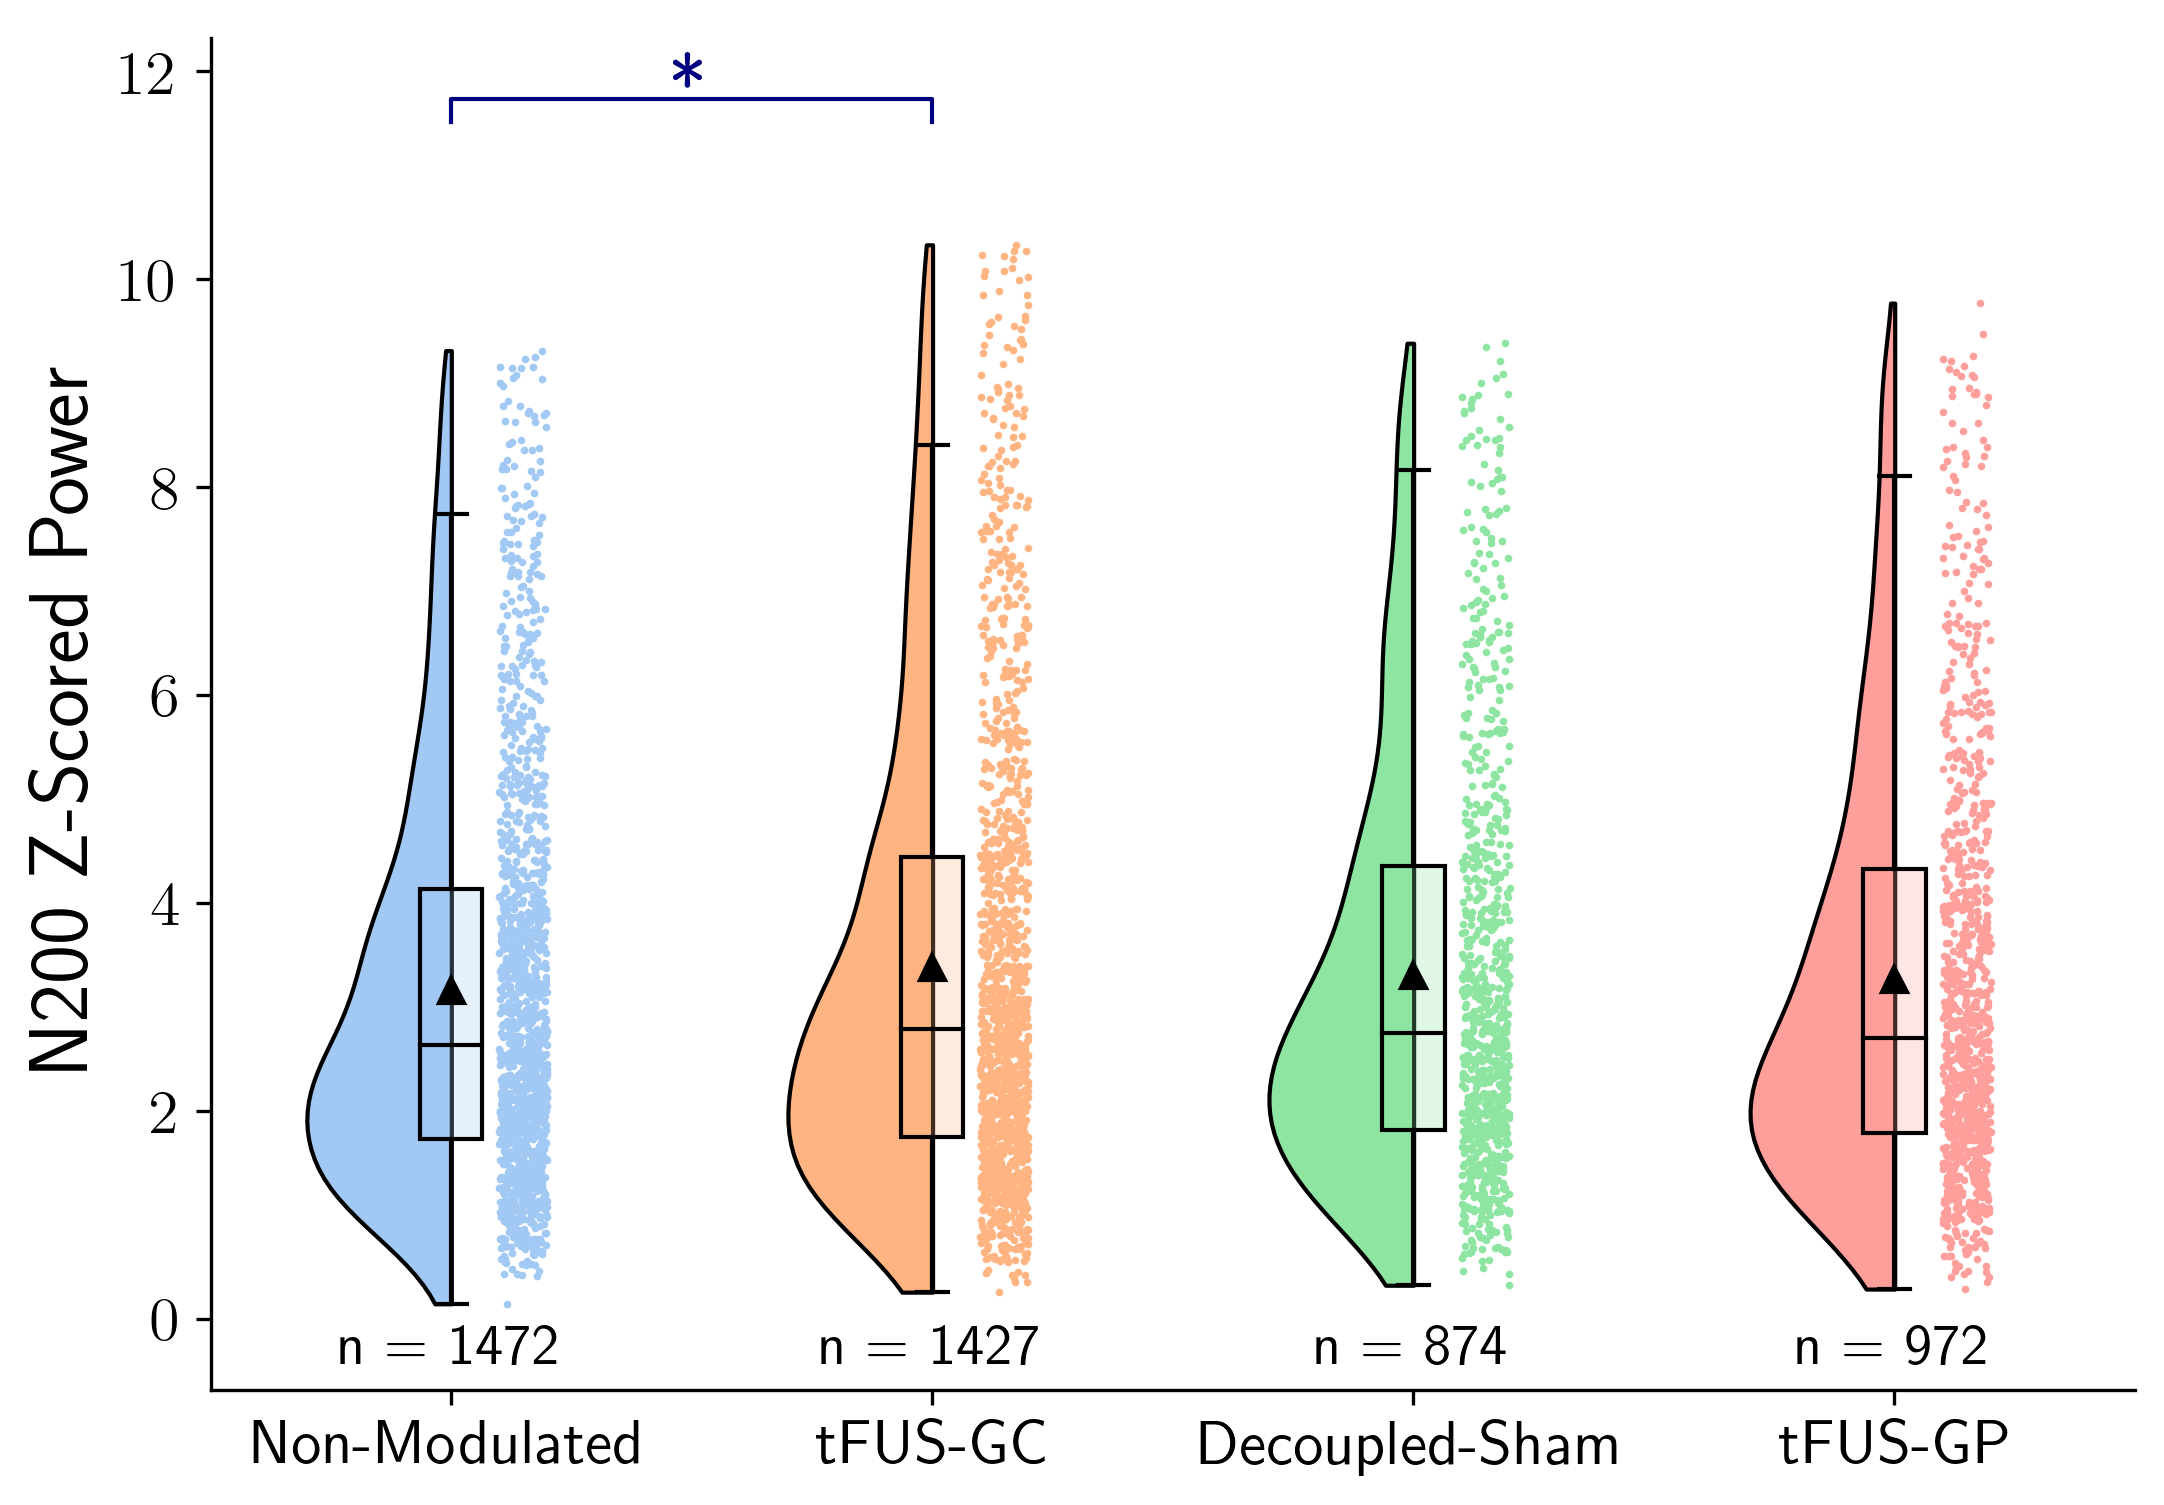

In [16]:
# P-Values were computed in R using lmer test
theta_ps = [
            [(2, 4), 3.226685e-05], # tFUS-US-Control
            [(2, 1), 1.203403e-06], # tFUS-NonModulated
            [(2, 3), 1.790883e-08], # tFUS-Decoupled
           ]

alpha_ps = [
            [(2, 4), 0.001240029], # tFUS-US-Control
            [(2, 1), 0.001240029], # tFUS-NonModulated
            [(2, 3), 0.001240029], # tFUS-Decoupled
           ]

beta_ps = [
            [(2, 1), 0.01414606], # tFUS-NonModulated
           ]

gamma_ps = [
            [(2, 1), 0.01436557], # tFUS-NonModulated
           ]

ps = [theta_ps, alpha_ps, beta_ps, gamma_ps]
for i, name in enumerate(["theta", "alpha", "beta", "gamma"]):

    my_df = pd.read_csv(f"/Users/jkosnoff/Downloads/Analysis_Rerun_SP_{name}_powers-IQR.csv")

    power_dicts = {}
    for cond in np.unique(my_df.condition):
        power_dicts[cond] = my_df["power"].loc[my_df.condition == cond].values


    data = []
    keys = ["Non-Modulated", "tFUS-GC", "Decoupled-Sham", "tFUS-GP"]
    for key in keys:
        data.append(power_dicts[key])
        print(name, key, np.mean(power_dicts[key]), np.std(power_dicts[key]))
        
        
    # Significant p values calculate in R w/ mixed effect modeling
    
    title = "" #r'Single Trial Euclidean Error, Normalized wrt $\sqrt{Scan Epochs}$ * Sonications'
    statistical_box_and_whisker(data, keys,
                                plot_type='raincloud',
                                title = "", 
                                y_label=r'N200 Z-Scored Power', 
                                print_ps = True, 
                                font = 'Arial',
                                show_means=True, 
                                significant_combinations = ps[i],
                                sig_color = 'navy',
                                save_fig = f"SP_{name}_N200.svg",
                                dpi = 300.0)

# IT

theta Non-Modulated 4.788357943389255 3.6654899362493993
theta tFUS-GC 4.911240052050863 3.5982545699873625
theta Decoupled-Sham 5.043336966826932 3.7102683391830977
theta tFUS-GP 4.410612522903828 3.2562347462326544
[[(2, 4), 0.00606883], [(1, 4), 0.0142949], [(3, 4), 0.00606883]]
Comparison between tFUS-GC and tFUS-GP: 0.00607
Comparison between Non-Modulated and tFUS-GP: 0.01429
Comparison between Decoupled-Sham and tFUS-GP: 0.00607


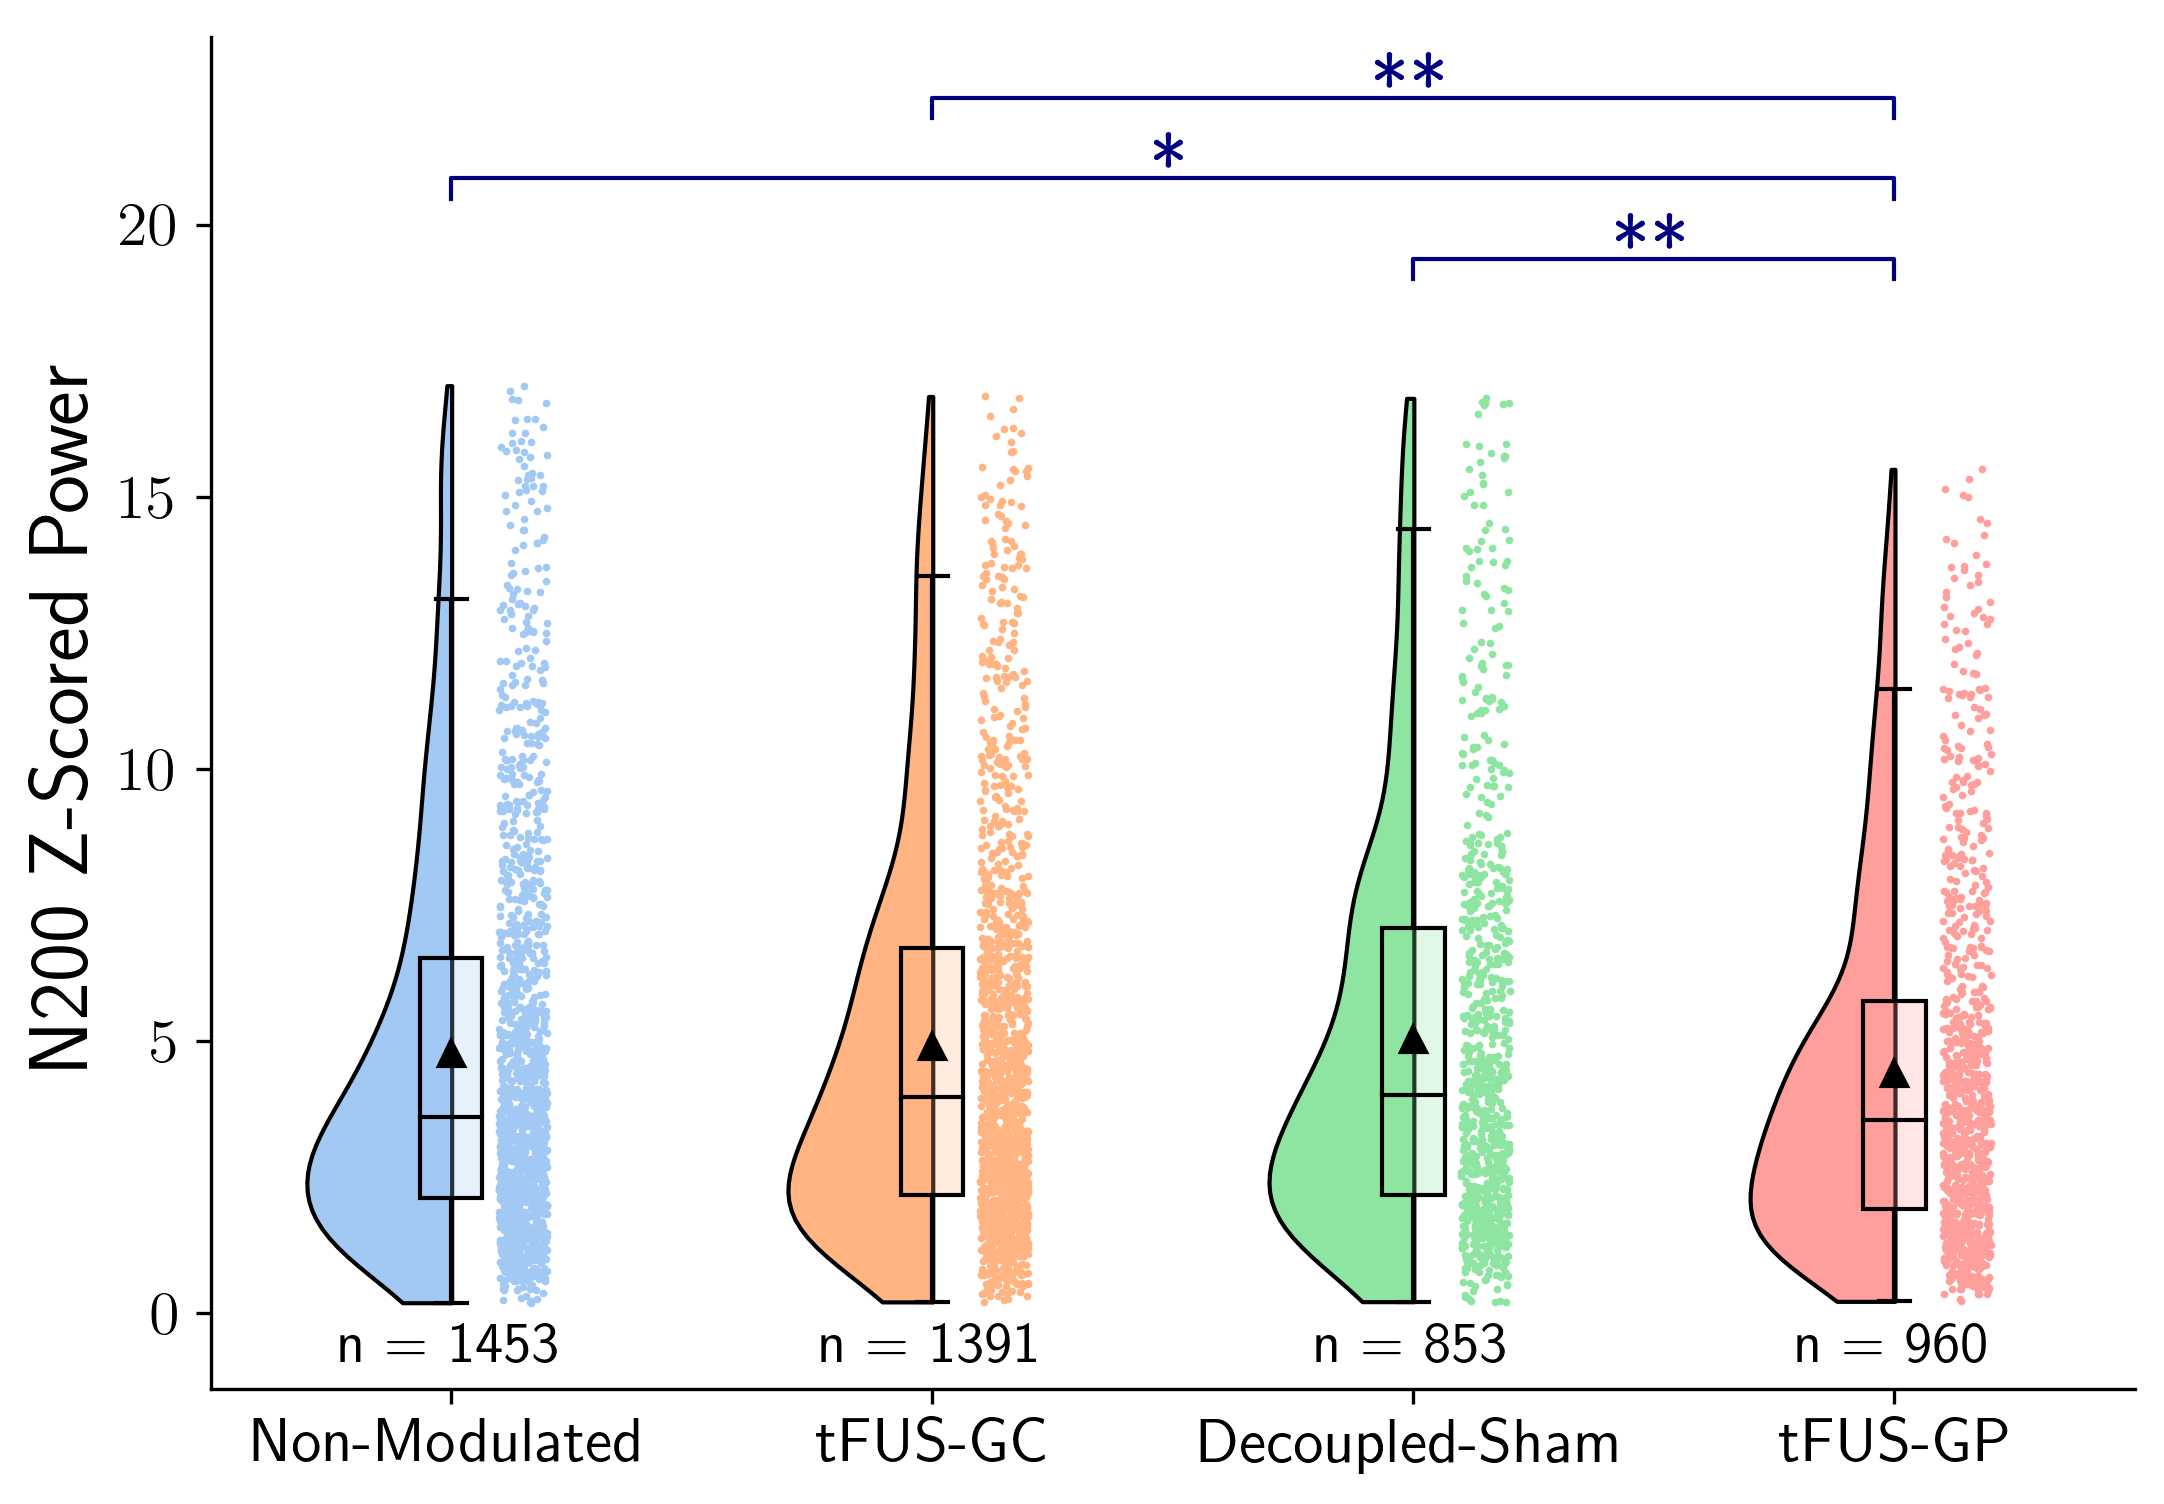

alpha Non-Modulated 4.019715867297739 2.7188498608386533
alpha tFUS-GC 4.013008377230638 2.5996637251123653
alpha Decoupled-Sham 4.289476877010969 2.880172748837952
alpha tFUS-GP 3.7477490452680753 2.570147666828437
[[(1, 4), 0.033975872], [(3, 4), 0.001857735]]
Comparison between Non-Modulated and tFUS-GP: 0.03398
Comparison between Decoupled-Sham and tFUS-GP: 0.00186


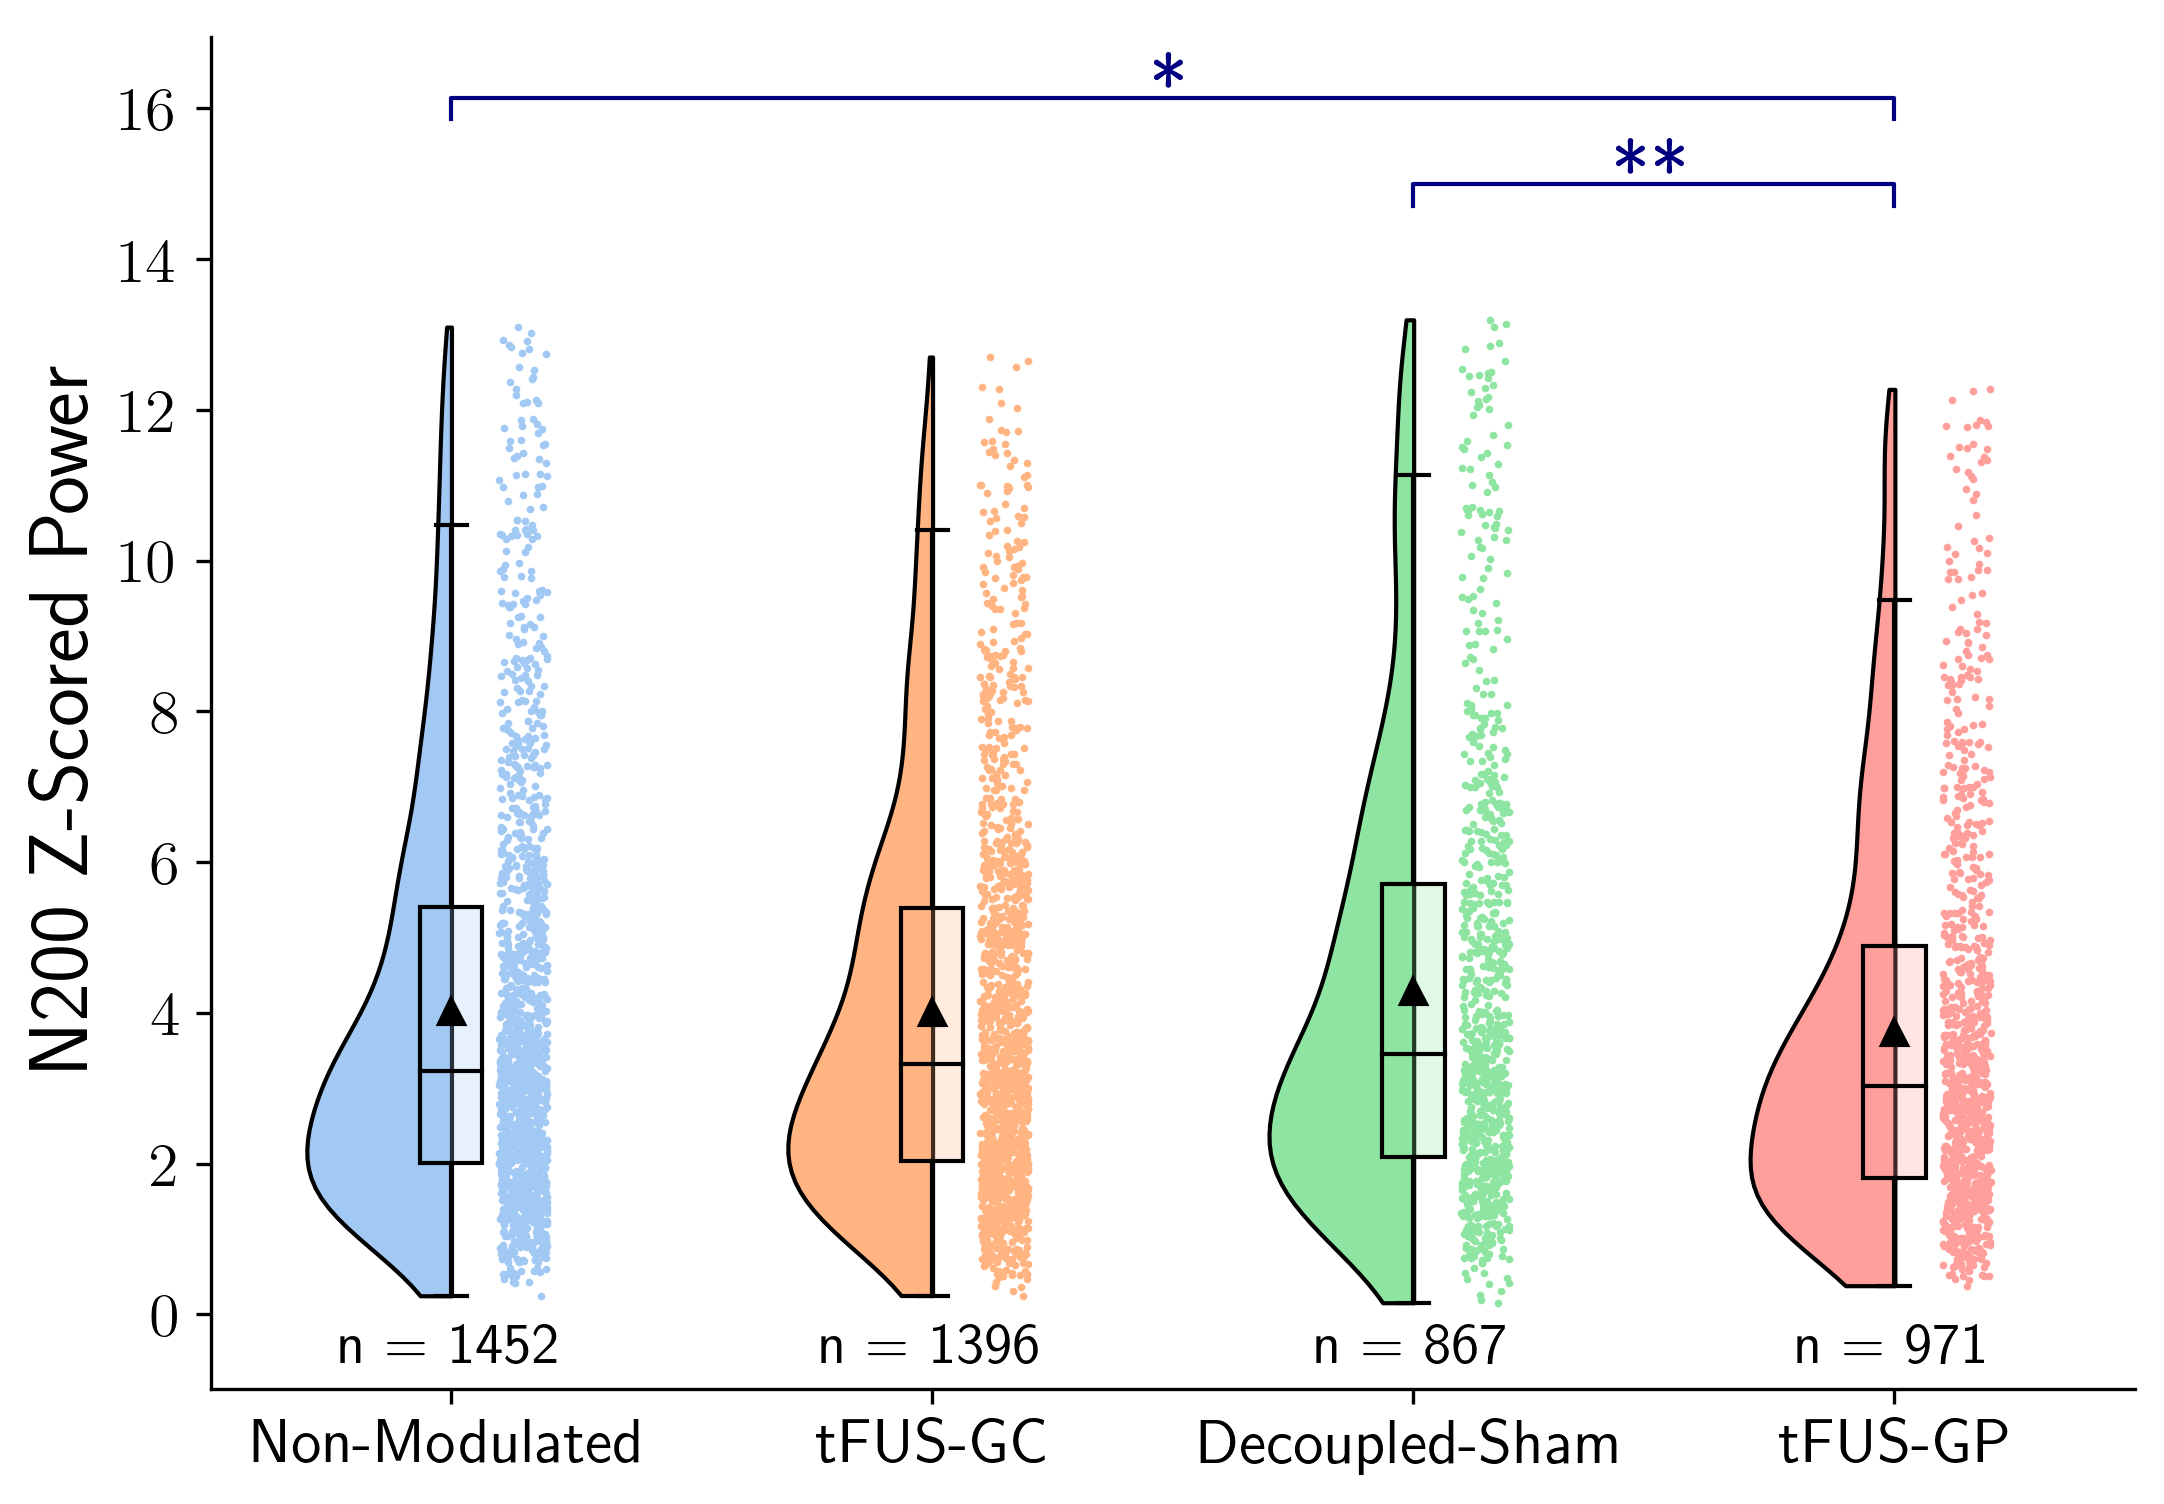

beta Non-Modulated 3.1513913785081495 1.9159733864198707
beta tFUS-GC 3.1608681295676675 1.9256296981966783
beta Decoupled-Sham 3.228083971116419 1.9151364605697159
beta tFUS-GP 2.9493437518403005 1.8909224550031067
[[(2, 4), 0.01760896], [(1, 4), 0.01760896], [(3, 4), 0.01760896]]
Comparison between tFUS-GC and tFUS-GP: 0.01761
Comparison between Non-Modulated and tFUS-GP: 0.01761
Comparison between Decoupled-Sham and tFUS-GP: 0.01761


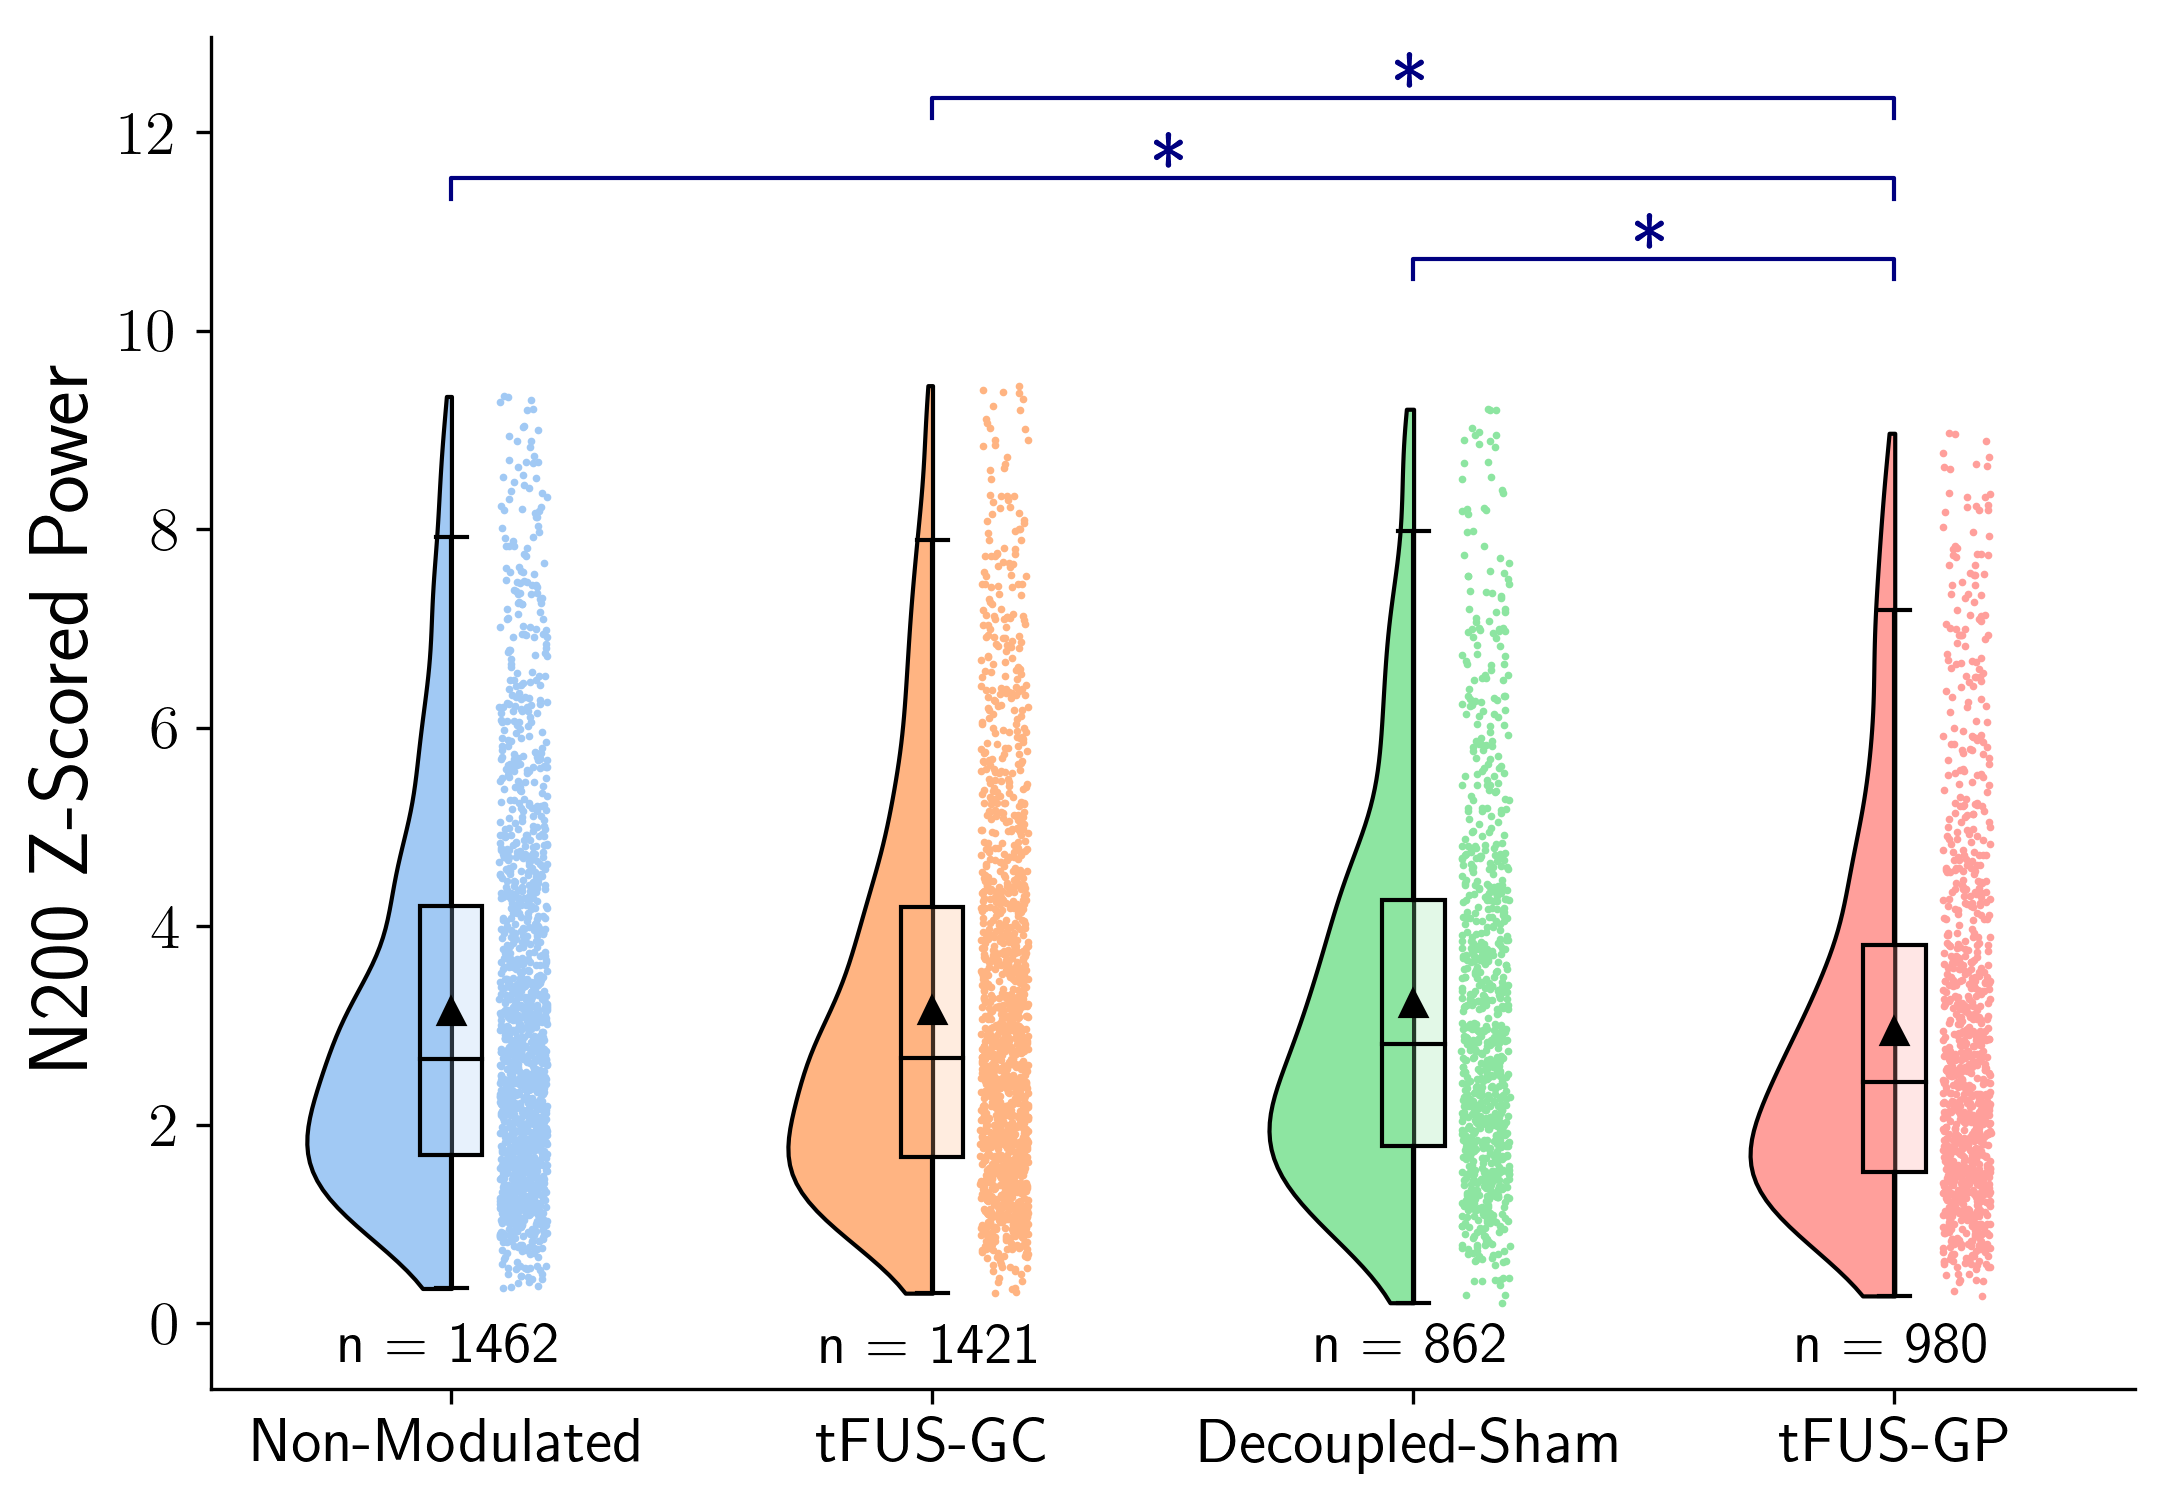

gamma Non-Modulated 2.9269517608209052 1.7767712444931782
gamma tFUS-GC 2.9177261884904726 1.7655236670537906
gamma Decoupled-Sham 2.9864664188029852 1.768210512931908
gamma tFUS-GP 2.7486648075727436 1.762922580453263
[[(2, 4), 0.04108025], [(1, 4), 0.029602], [(3, 4), 0.029602]]
Comparison between tFUS-GC and tFUS-GP: 0.04108
Comparison between Non-Modulated and tFUS-GP: 0.02960
Comparison between Decoupled-Sham and tFUS-GP: 0.02960


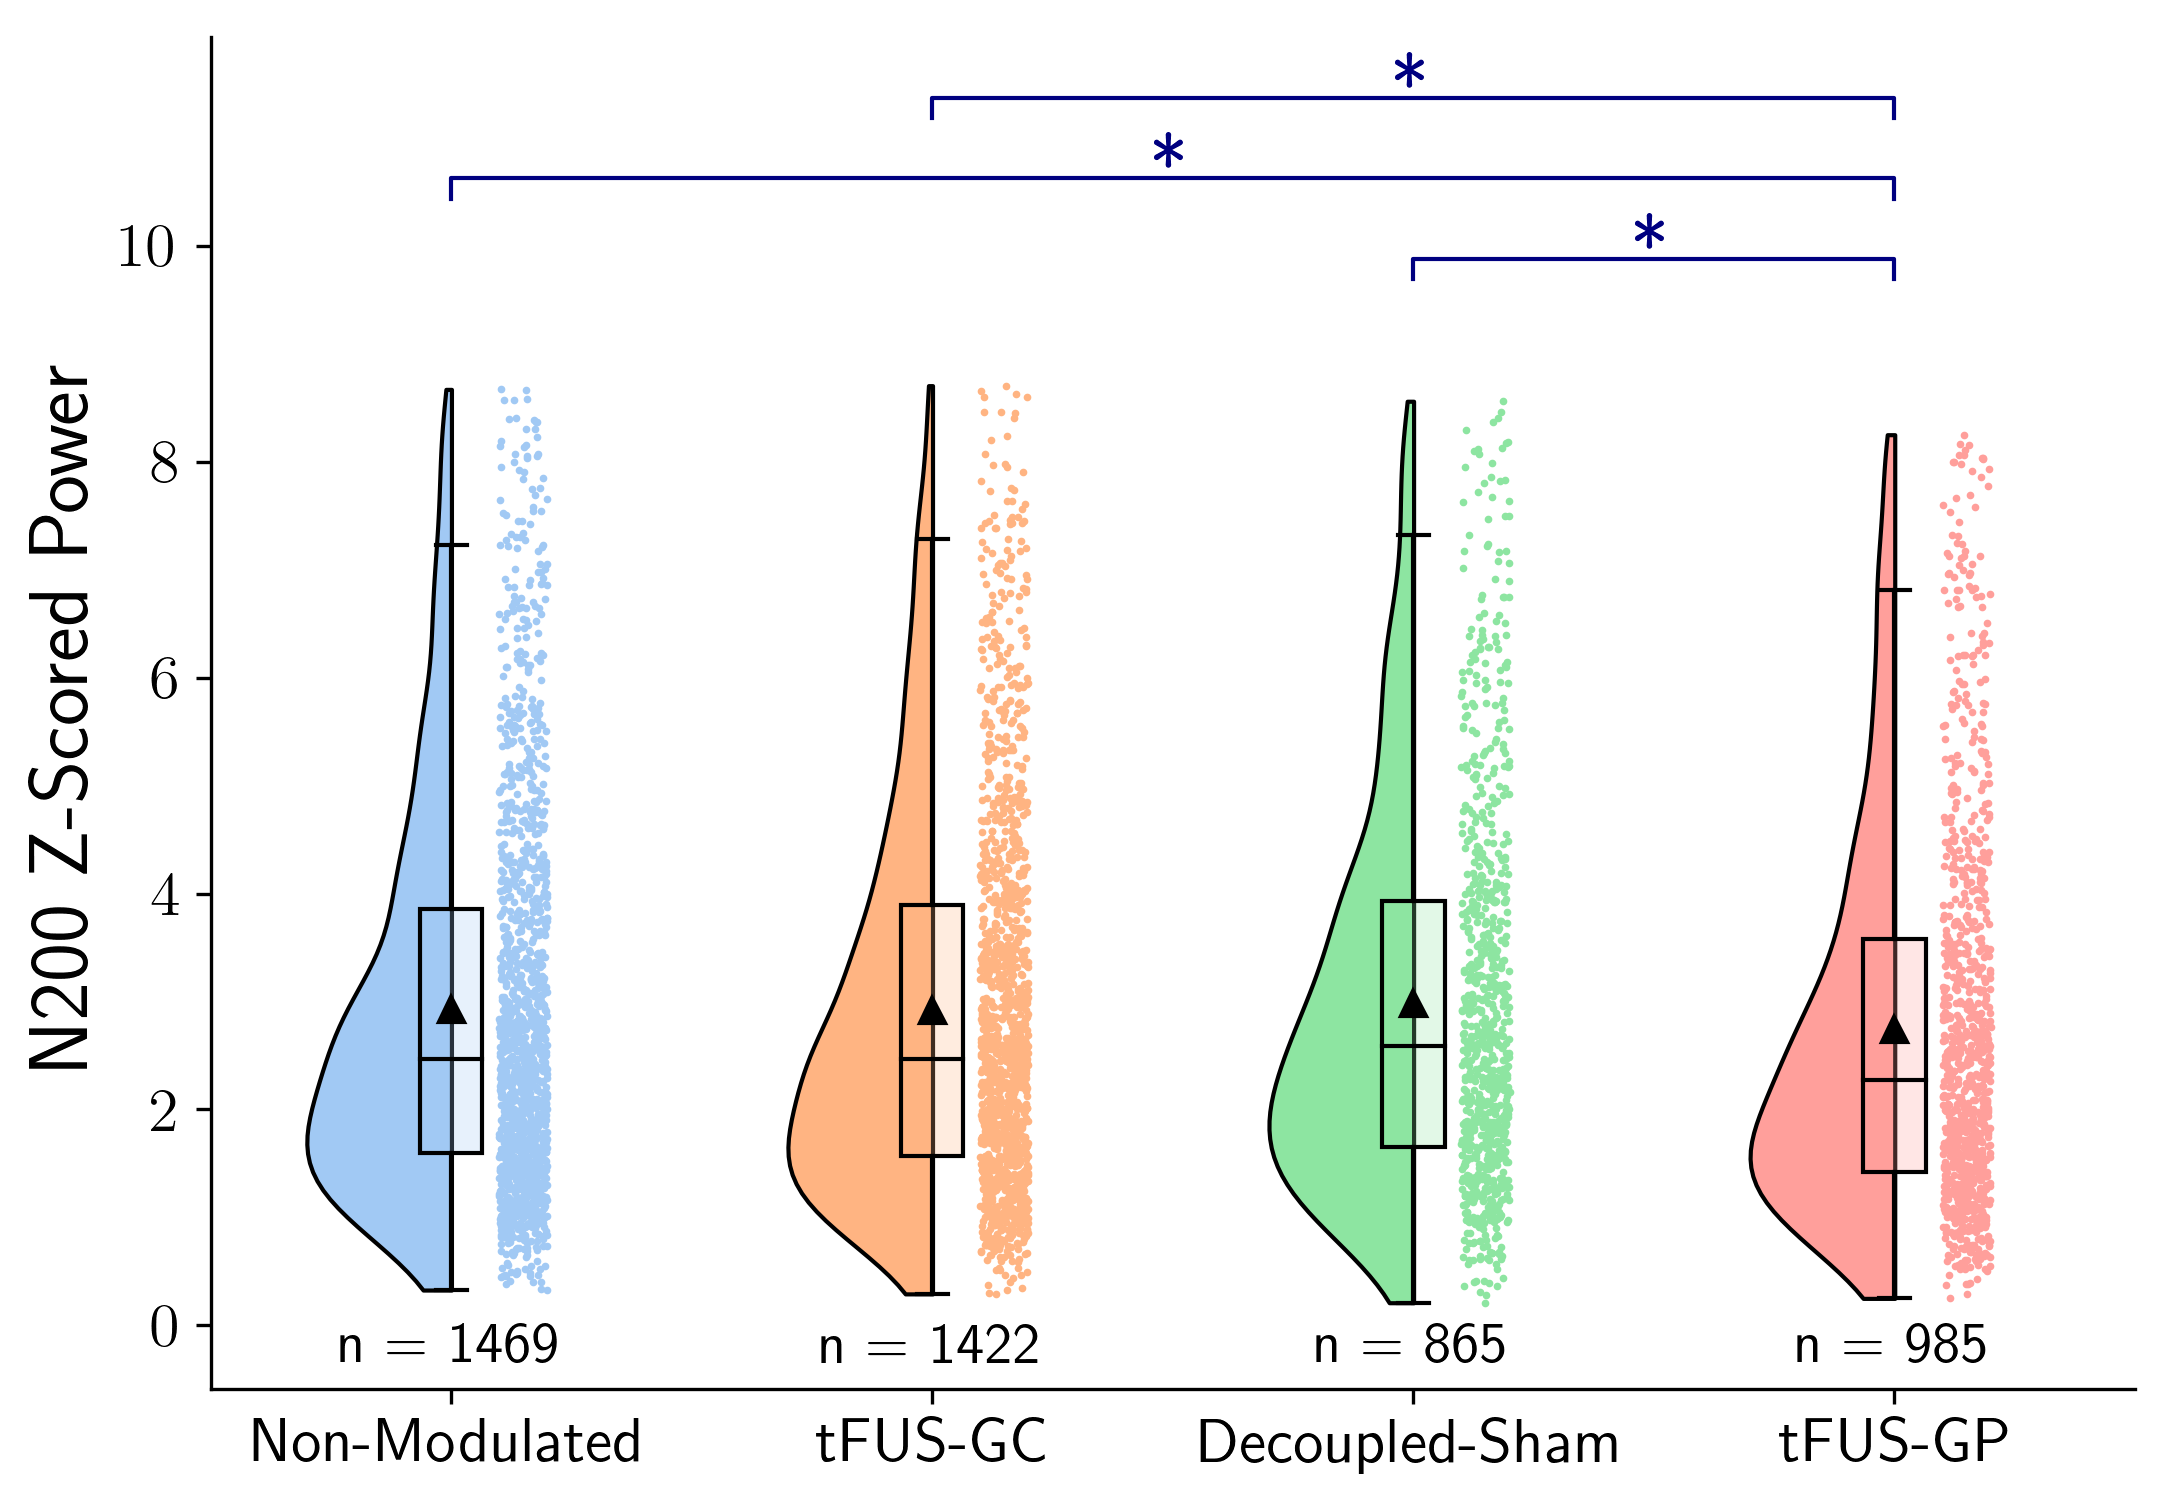

In [17]:
# P-Values were computed in R using lmer test

theta_ps = [[(2, 4), 0.00606883], # tFUS-US-Control
            [(1, 4), 0.01429490], # US-Control - NonModulated
            [(3, 4), 0.00606883], # US-Control - Decoupled Sham
           ]

alpha_ps = [
            [(1, 4), 0.033975872], # US-Control - NonModulated
            [(3, 4), 0.001857735], # US-Control - Decoupled Sham
           ]

beta_ps = [
            [(2, 4), 0.01760896], # tFUS-US-Control
            [(1, 4), 0.01760896], # US-Control - NonModulated
            [(3, 4), 0.01760896], # US-Control - Decoupled Sham
           ]

gamma_ps = [
            [(2, 4), 0.04108025], # tFUS-US-Control
            [(1, 4), 0.02960200], # US-Control - NonModulated
            [(3, 4), 0.02960200], # US-Control - Decoupled Sham
           ]

ps = [theta_ps, alpha_ps, beta_ps, gamma_ps]
for i, name in enumerate(["theta", "alpha", "beta", "gamma"]):

    my_df = pd.read_csv(f"/Users/jkosnoff/Downloads/Analysis_Rerun_IT_{name}_powers-IQR.csv")

    power_dicts = {}
    for cond in np.unique(my_df.condition):
        power_dicts[cond] = my_df["power"].loc[my_df.condition == cond].values


    data = []
    keys = ["Non-Modulated", "tFUS-GC", "Decoupled-Sham", "tFUS-GP"]
    for key in keys:
        data.append(power_dicts[key])
        print(name, key, np.mean(power_dicts[key]), np.std(power_dicts[key]))
        

    # Significant p values calculate in R w/ mixed effect modeling
    

    title = "" #r'Single Trial Euclidean Error, Normalized wrt $\sqrt{Scan Epochs}$ * Sonications'
    statistical_box_and_whisker(data, keys,
                                plot_type='raincloud',
                                title = "", 
                                y_label=r'N200 Z-Scored Power', 
                                print_ps = True, 
                                font = 'Arial',
                                show_means=True, 
                                significant_combinations = ps[i],
                                sig_color = 'navy',
                                save_fig = f"IT_{name}_N200.svg",
                                dpi = 300.0)

In [12]:
import session_info
session_info.show()